In [300]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.stats import multivariate_normal
from sklearn import linear_model
from matplotlib.colors import LogNorm
import pickle
import tqdm
import pandas as pd

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
import itertools

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (16,10)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [172]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

## Q-learinig 

In [96]:
class Pi:
    def __init__(self, n_rows, n_cols):
        actions = list(itertools.product(range(N_ROWS), range(N_COLS)))
        self.Q = {'1' * n_rows * n_cols: self._random_init_state(actions)}
        self.random = False
        
    def _random_init_state(self, actions):
        return dict([(tuple(action), random.random()) for action in actions])
    
    def select_greedy_action(self, state):
        max_action = float('-inf')
        best_action = None
        for action, val in self.Q[state].items():
            if val > max_action:
                max_action = val
                best_action = action
        return best_action
    
    def update_states(self, state, actions):
        if state not in self.Q:
            self.Q[state] = self._random_init_state(actions)
            
    def max_Q(self, state):
        return max(self.Q[state].values())

In [285]:
def Q_learning_episodes(env, num_episodes, alpha=0.05, epsilon=0.0, gamma=0.9):
    def get_s_a(state, actions, pi):
        s, a = state, pi.select_greedy_action(state) if random.random() > epsilon else random.choice(actions)
        return s, tuple(a)

    def init(env):
        env.reset()
        s, a = env.getState()[:2]
        return (*get_s_a(s, a, pi_x)), None, None

    rewards_x = []
    rewards_o = []
    pi_x = Pi(env.n_rows, env.n_cols)
    pi_o = Pi(env.n_rows, env.n_cols)
    
    for _ in tqdm.notebook.tqdm(range(num_episodes)):
        s_x, a_x, s_o, a_o = init(env)
        while True:
            state, reward, done, info = env.step(a_x if env.curTurn == 1 else a_o)
            if done:
                rewards_x.append(reward)
                rewards_o.append(-reward)
                pi_x.Q[s_x][a_x] = (1 - alpha) * pi_x.Q[s_x][a_x] + alpha * reward
                pi_o.Q[s_o][a_o] = (1 - alpha) * pi_o.Q[s_o][a_o] + alpha * -reward
                
            else:
                if env.curTurn == 1:
                    pi_x.update_states(*state[:2])
                    s_x_prime, a_x_prime = get_s_a(*state[:2], pi_x)
                    pi_x.Q[s_x][a_x] = (1 - alpha) * pi_x.Q[s_x][a_x] + alpha * (reward + gamma * pi_x.max_Q(s_x_prime))
                    s_x, a_x = s_x_prime, a_x_prime
                else:
                    pi_o.update_states(*state[:2])
                    if s_o is None:
                        s_o, a_o = get_s_a(*state[:2], pi_o)
                    else:
                        pi_o.update_states(*state[:2])
                        s_o_prime, a_o_prime = get_s_a(*state[:2], pi_o)
                        pi_o.Q[s_o][a_o] = (1 - alpha) * pi_o.Q[s_o][a_o] + alpha * (reward + gamma * pi_o.max_Q(s_o_prime))
                        s_o, a_o = s_o_prime, a_o_prime
            if done:
                s_x, a_x, s_o, a_o = init(env)
                break
    return (np.cumsum(rewards_x) / (np.arange(len(rewards_x)) + 1), 
            np.cumsum(rewards_o) / (np.arange(len(rewards_o)) + 1), 
            pi_x, pi_o)

In [286]:
def run_best_Q_strategy(env, pi_x, pi_o, num_episodes):
    def get_s_a(state, actions, pi):
        s, a = state, pi.select_greedy_action(state) if not pi.random else random.choice(actions)
        return s, tuple(a)

    def init(env):
        env.reset()
        s, a = env.getState()[:2]
        return get_s_a(s, a, pi_x)
    
    rewards_x = []
    rewards_o = []
    
    for _ in range(num_episodes):
        s, a = init(env)
        while True:
            state, reward, done, info = env.step(a)
            if done:
                rewards_x.append(reward)
                rewards_o.append(-reward)
                s, a = init(env)
                break
            else:
                if env.curTurn == 1:
                    pi_x.update_states(*state[:2])
                    s, a = get_s_a(*state[:2], pi_x)
                else:
                    pi_o.update_states(*state[:2])
                    s, a = get_s_a(*state[:2], pi_o)
    return (np.cumsum(rewards_x) / (np.arange(len(rewards_x)) + 1), 
            np.cumsum(rewards_o) / (np.arange(len(rewards_o)) + 1))

### 3x3

In [56]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [57]:
num_episodes = 50000
gamma = 1
alpha = 0.9
epsilon = 0.01

env = TicTacToe(N_ROWS, N_COLS, N_WIN)
rewards_x, rewards_o, pi_x, pi_o = Q_learning_episodes(env, num_episodes, 
                                                       alpha=alpha, epsilon=epsilon, gamma=gamma)

/Users/donfa1con/.virtualenvs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


States length: X - 2364, O - 1996


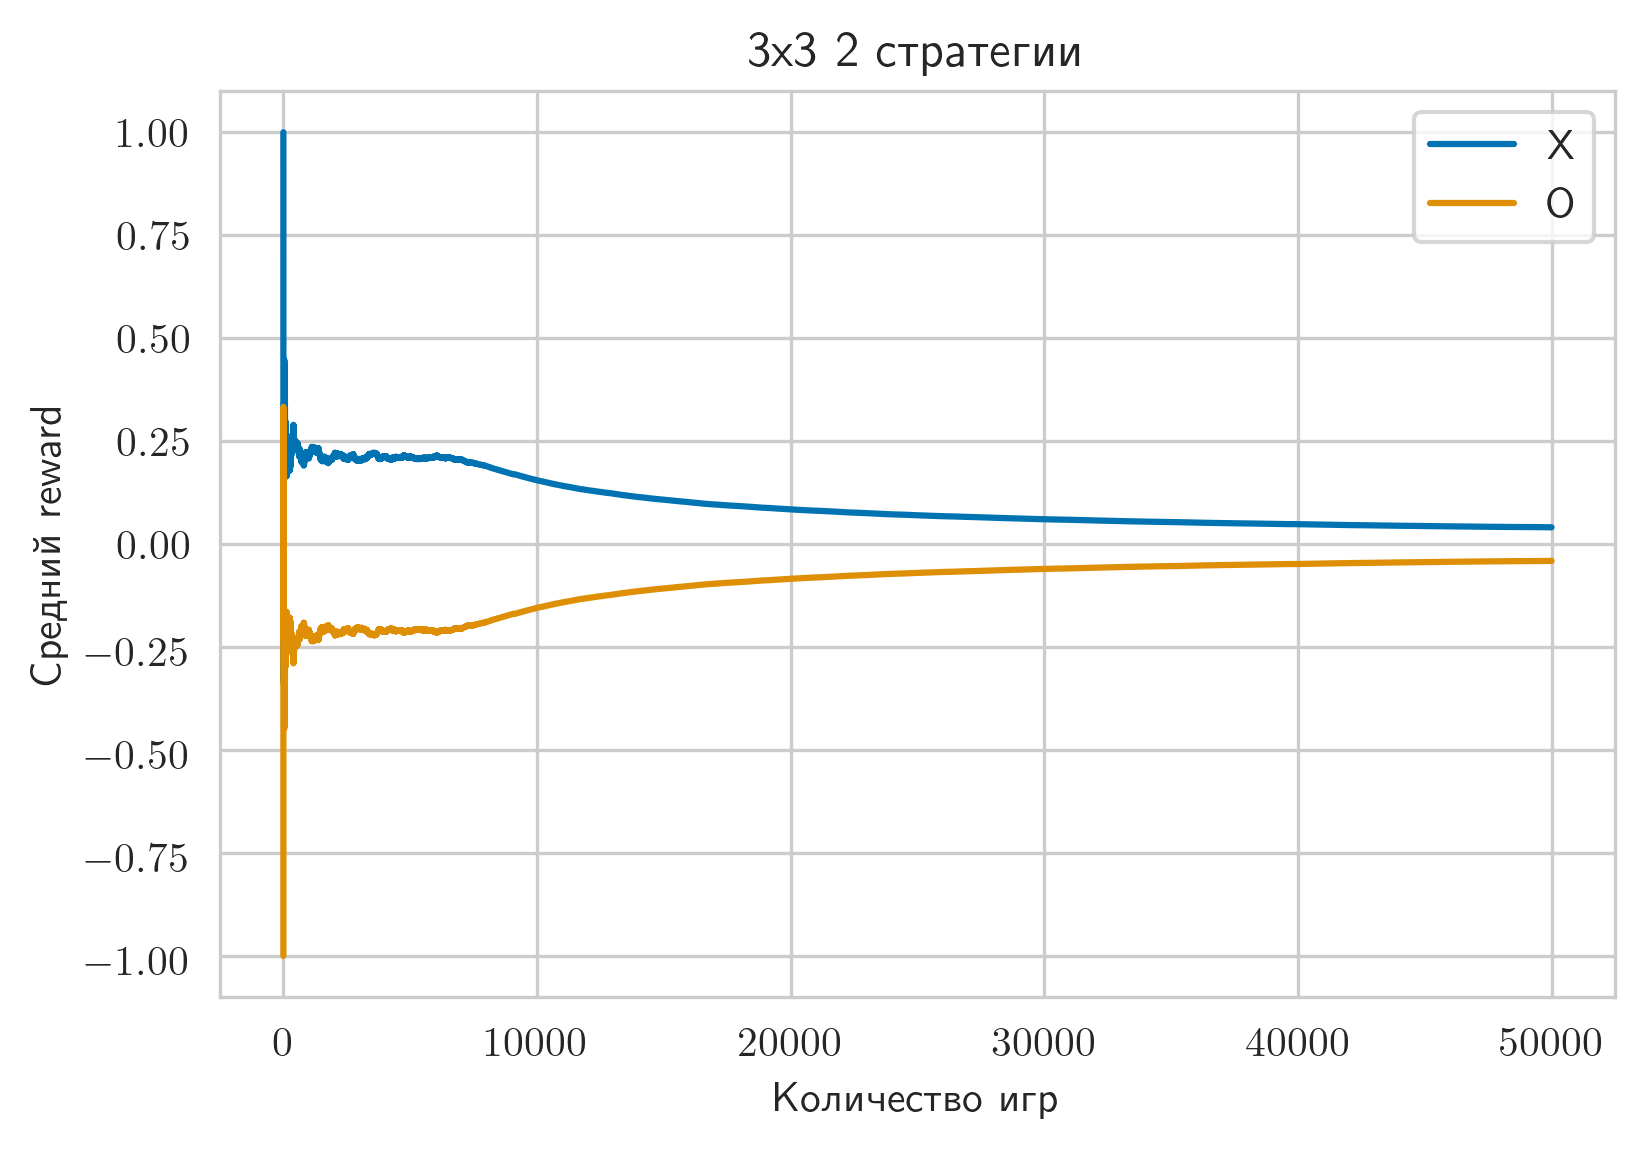

In [58]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

In [60]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

States length: X - 2364, O - 1996


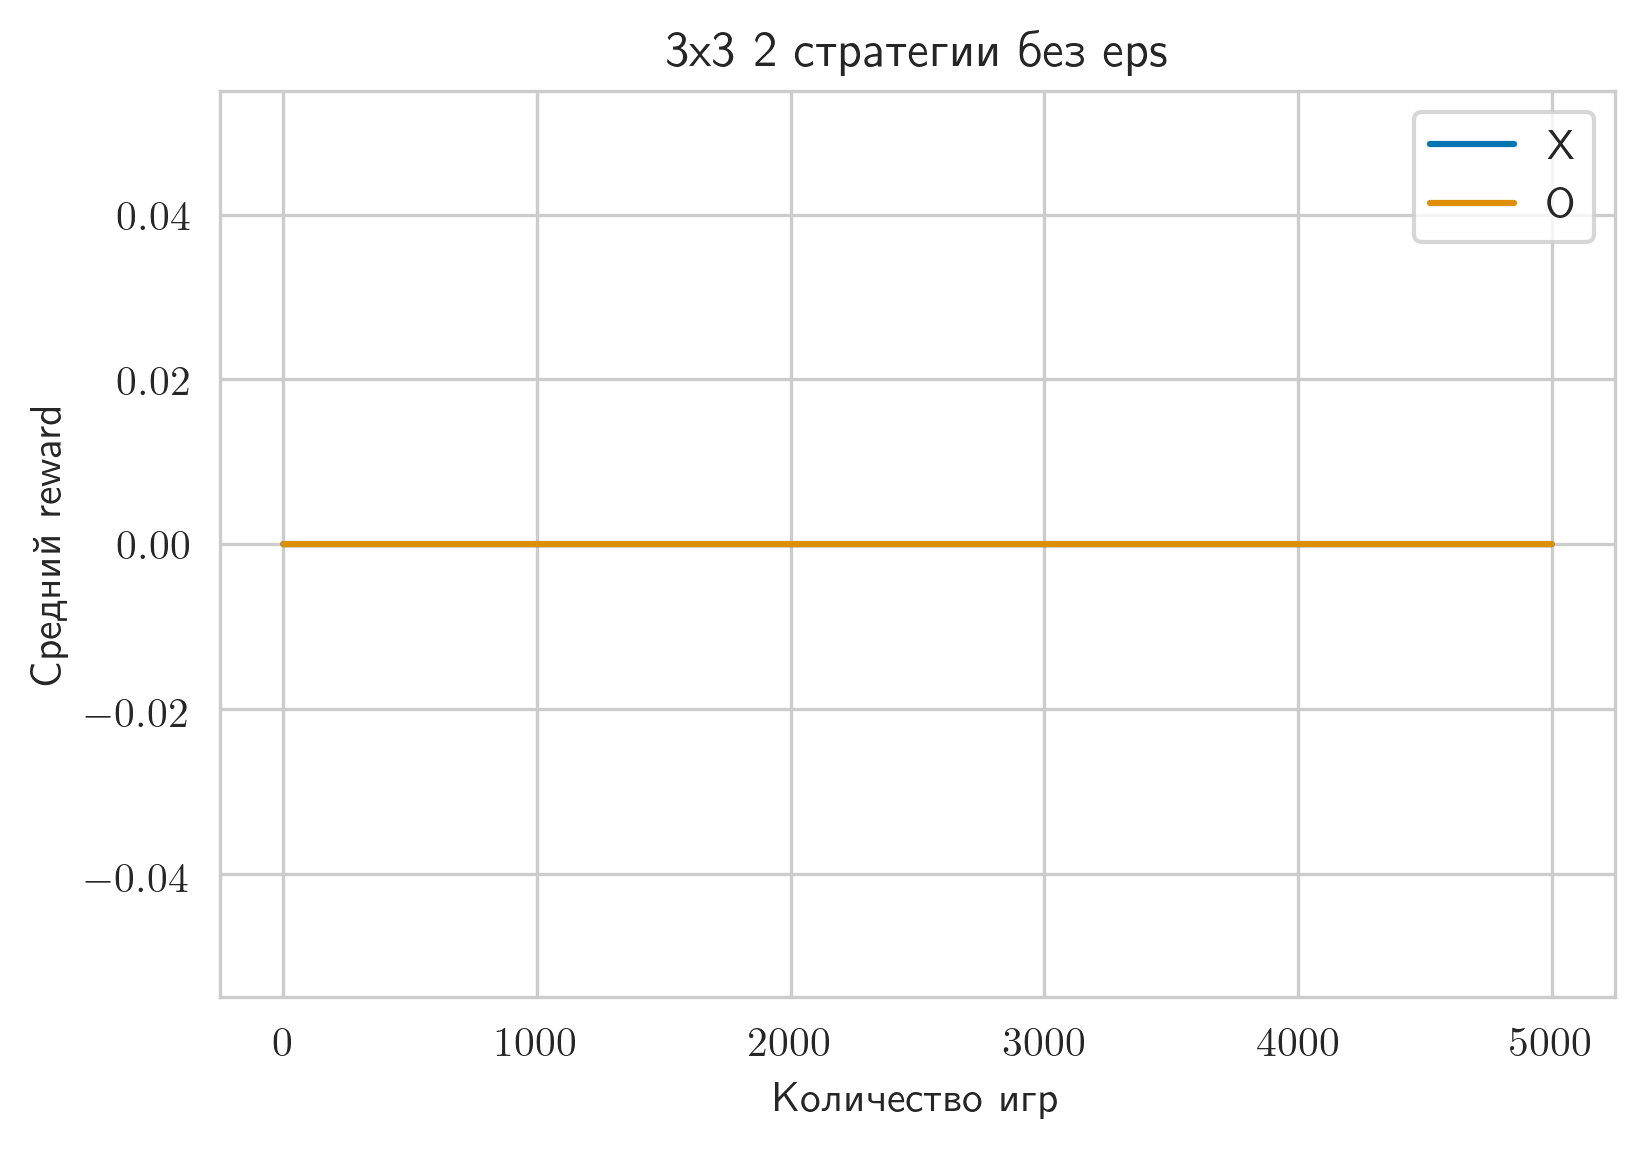

In [61]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

2 стратегии играют в ничью

In [62]:
num_episodes = 5000
pi_x.random = True
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

States length: X - 2364, O - 1996


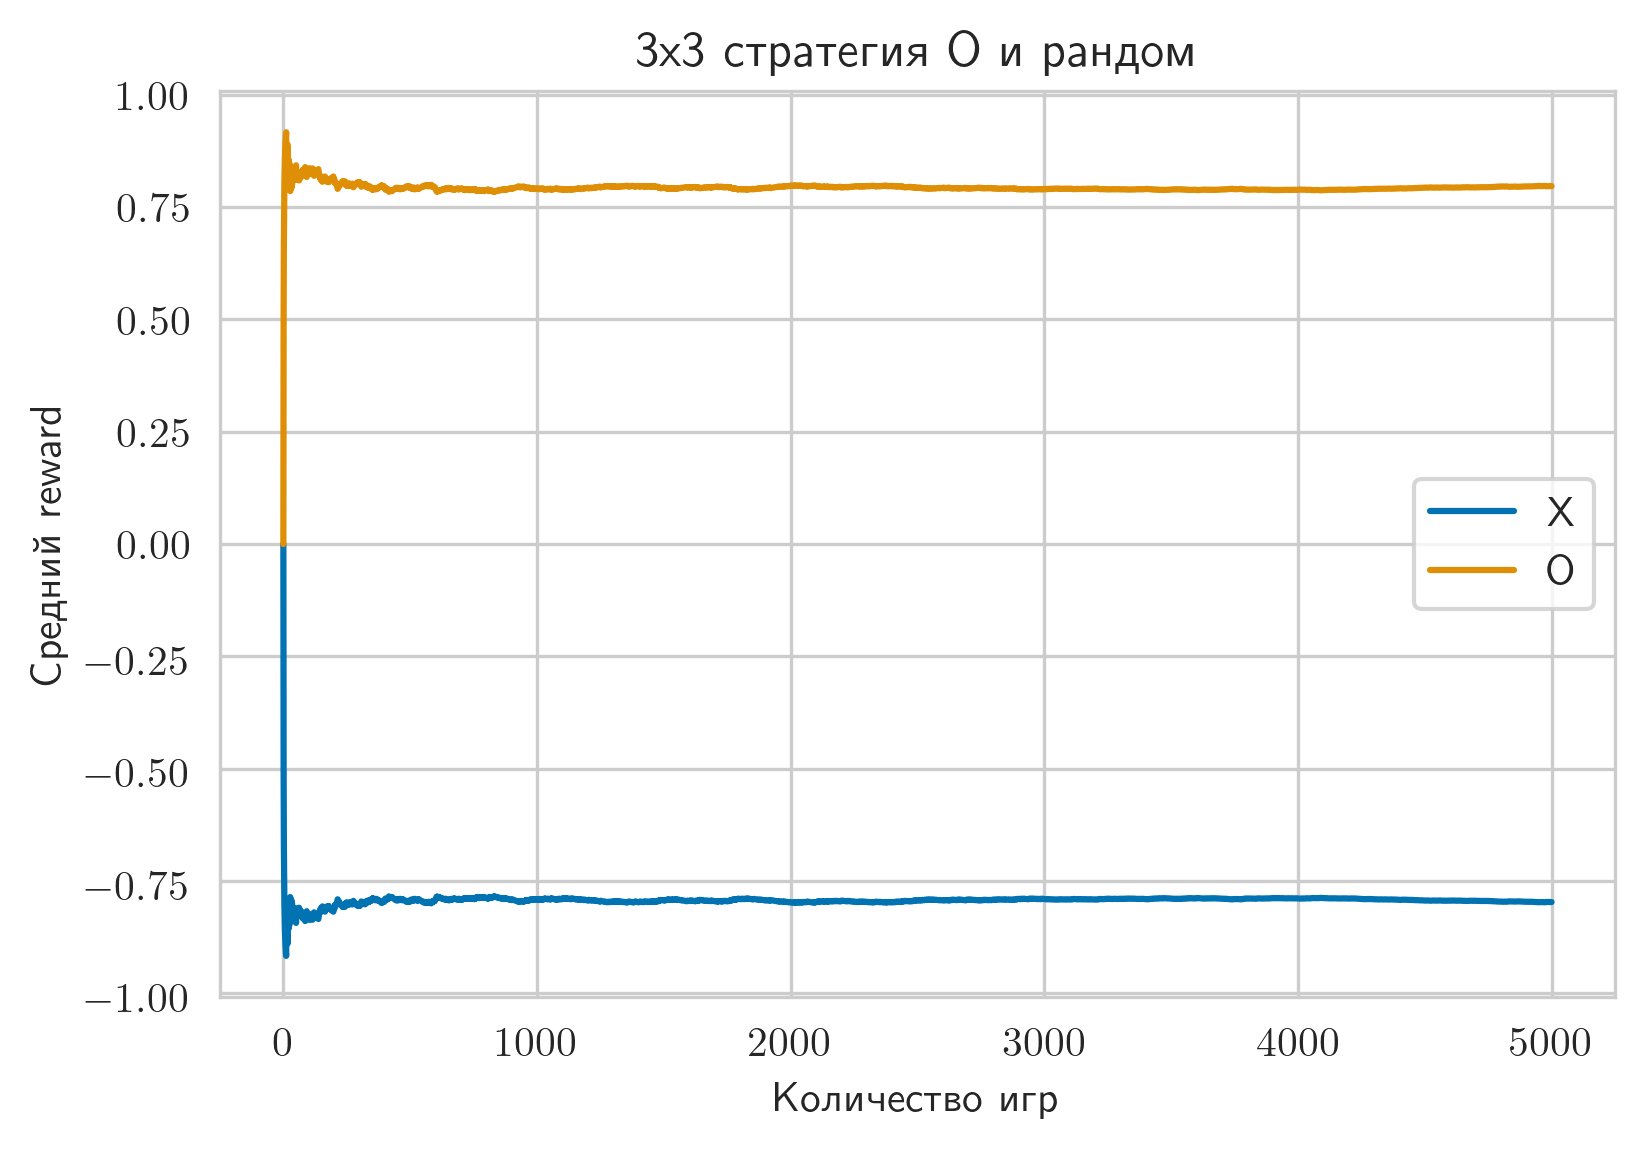

In [63]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 стратегия О и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

In [64]:
num_episodes = 5000
pi_x.random = False
pi_o.random = True
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

States length: X - 2364, O - 1996


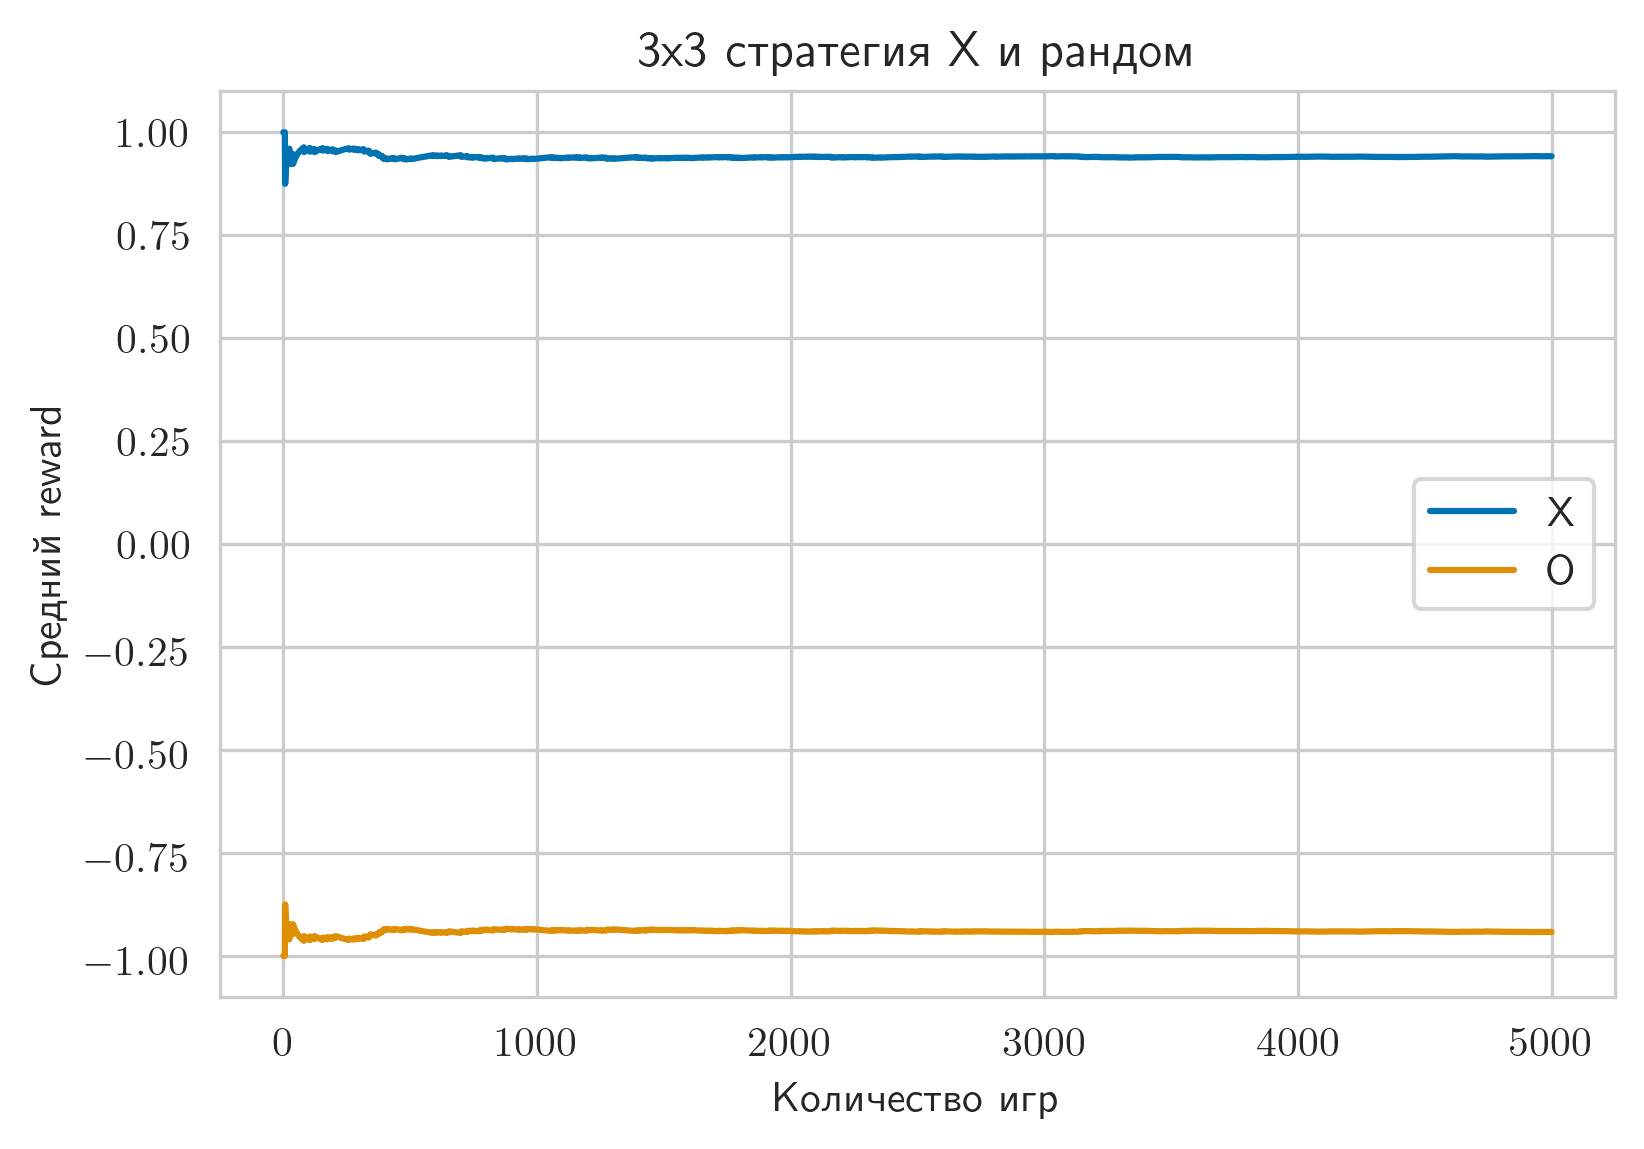

In [65]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

### 4x4 3 в ряд

In [68]:
N_ROWS, N_COLS, N_WIN = 4, 4, 3

In [76]:
num_episodes = 500000
gamma = 1
alpha = 0.9
epsilon = 0.1

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
rewards_x, rewards_o, pi_x, pi_o = Q_learning_episodes(env, num_episodes, 
                                                       alpha=alpha, epsilon=epsilon, gamma=gamma)

/Users/donfa1con/.virtualenvs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


States length: X - 426375, O - 391922


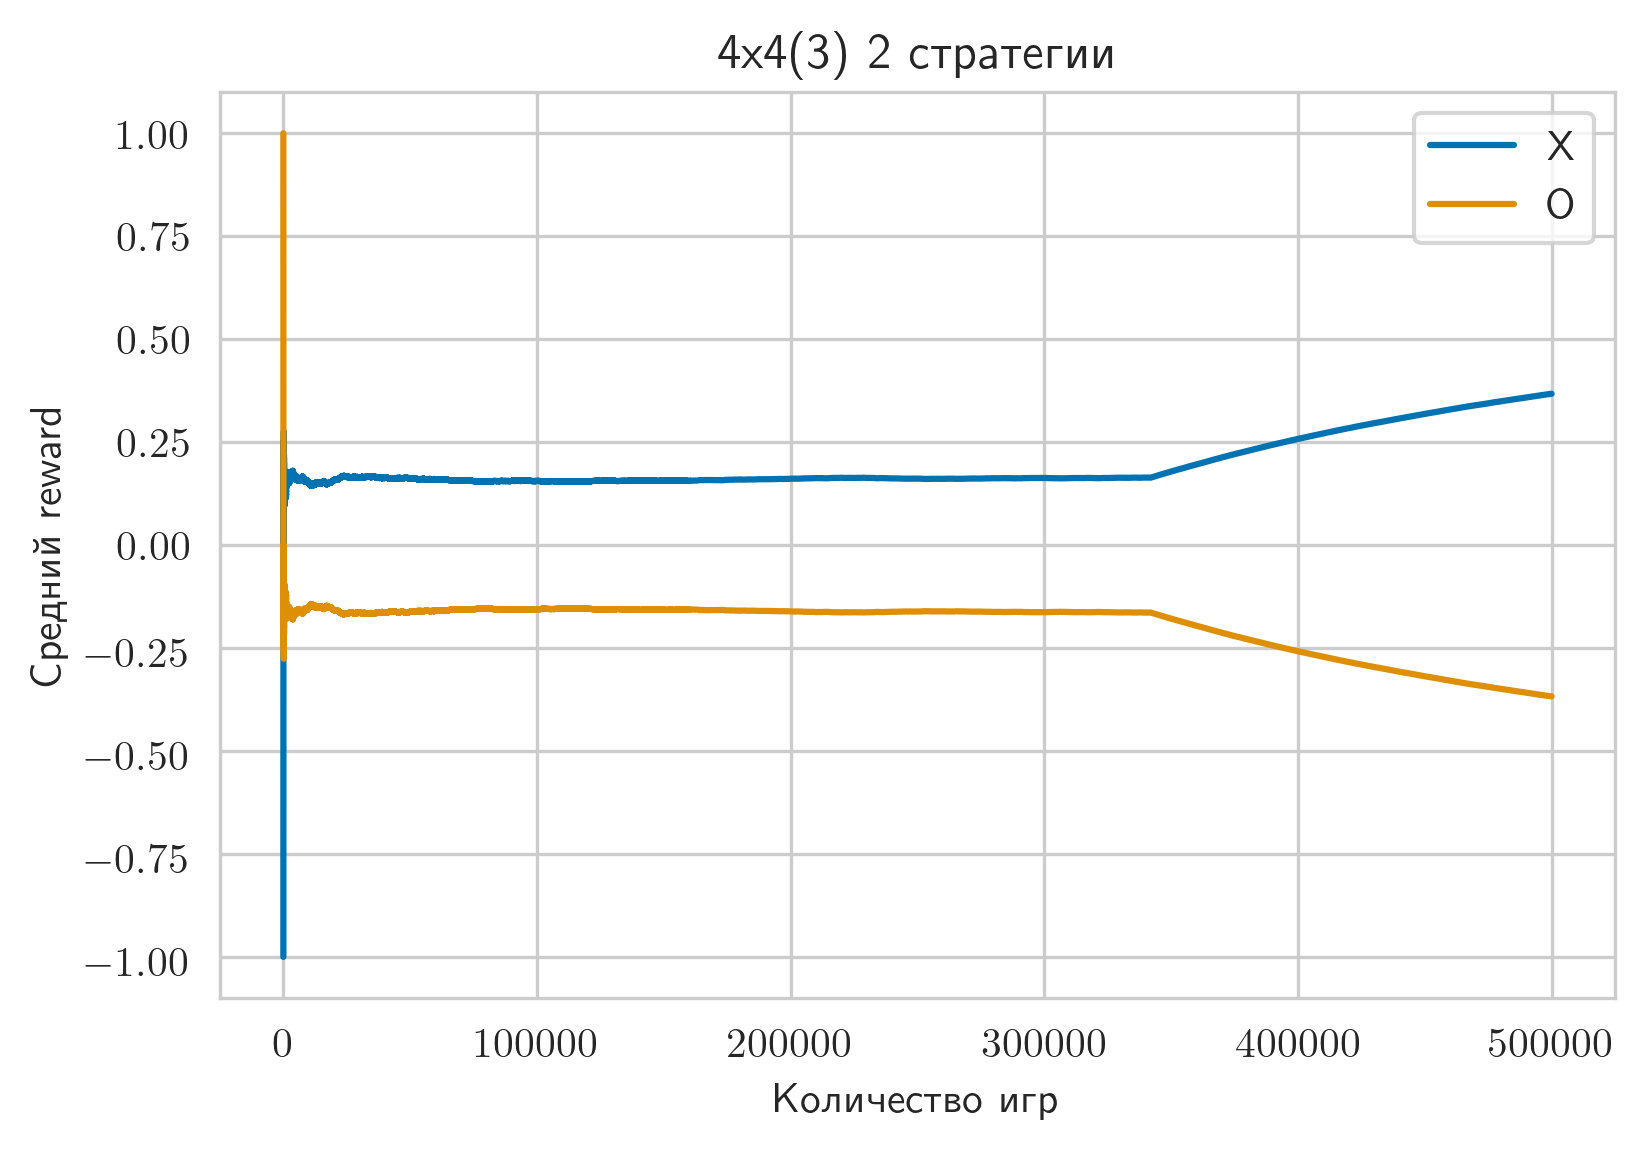

In [77]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(3) 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

In [78]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

States length: X - 426375, O - 391922


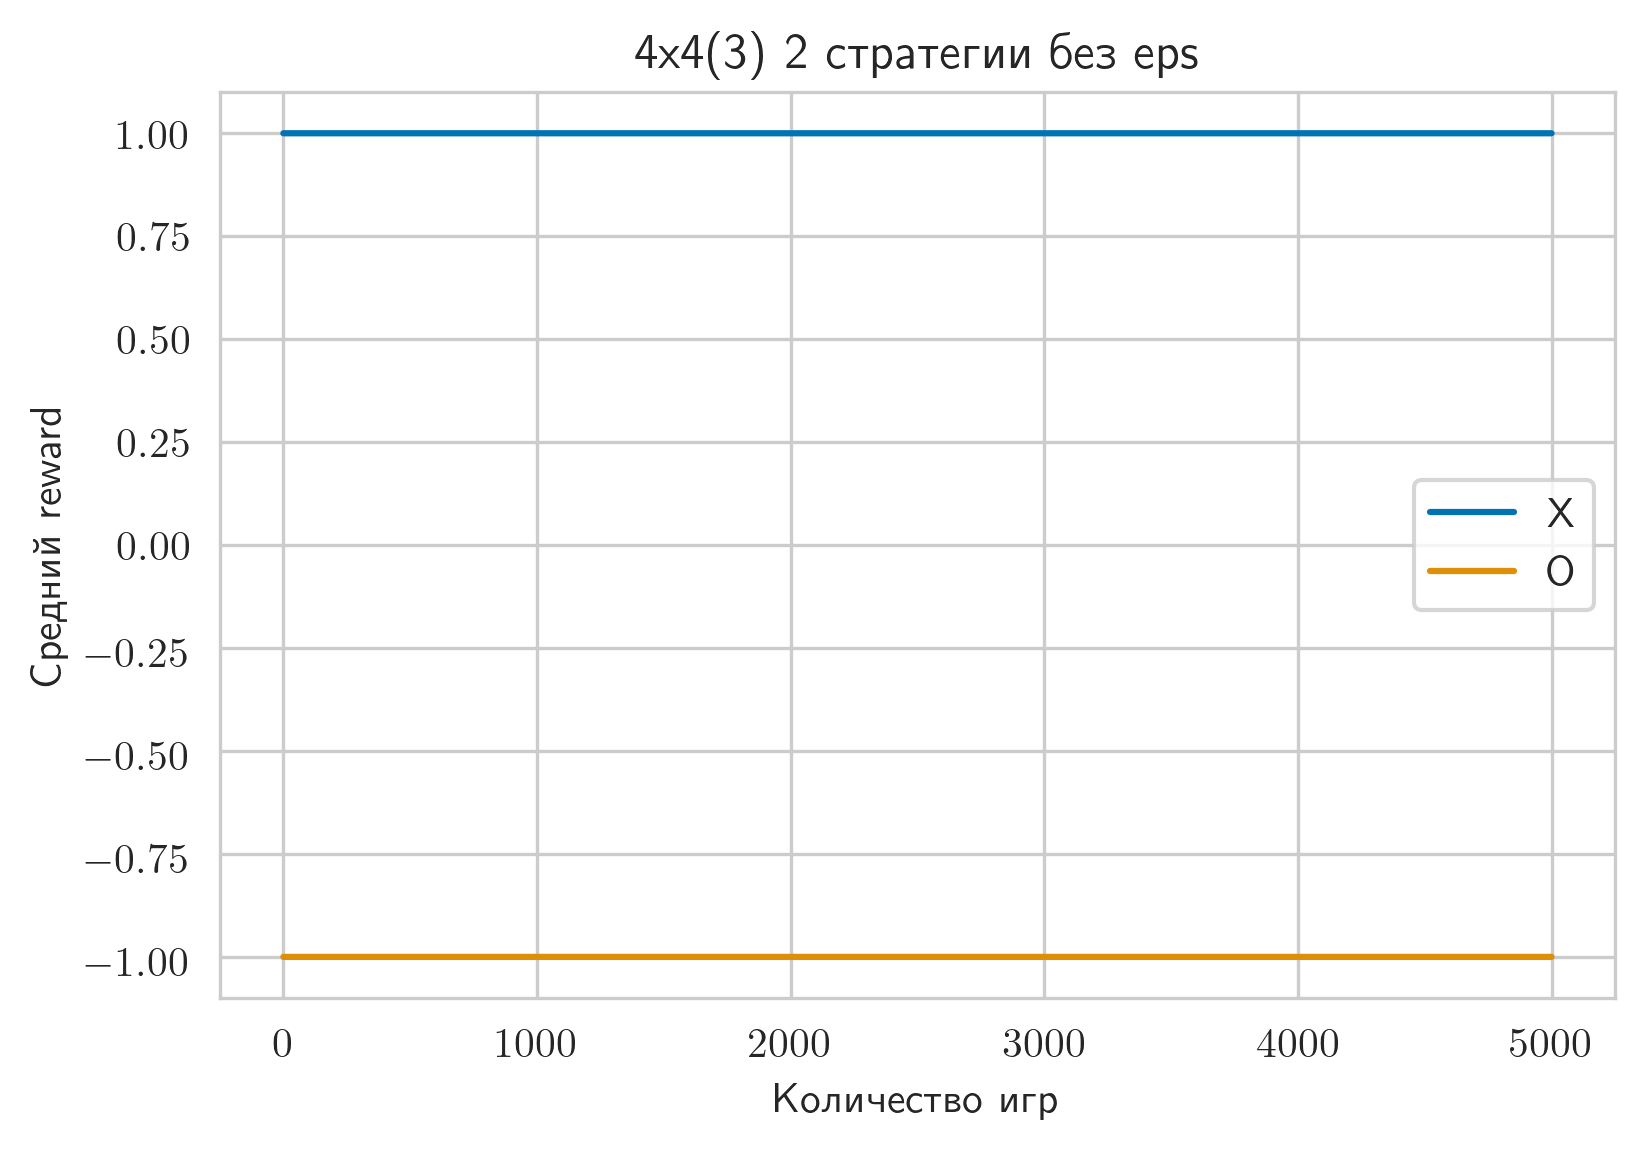

In [79]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(3) 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

States length: X - 435188, O - 404353


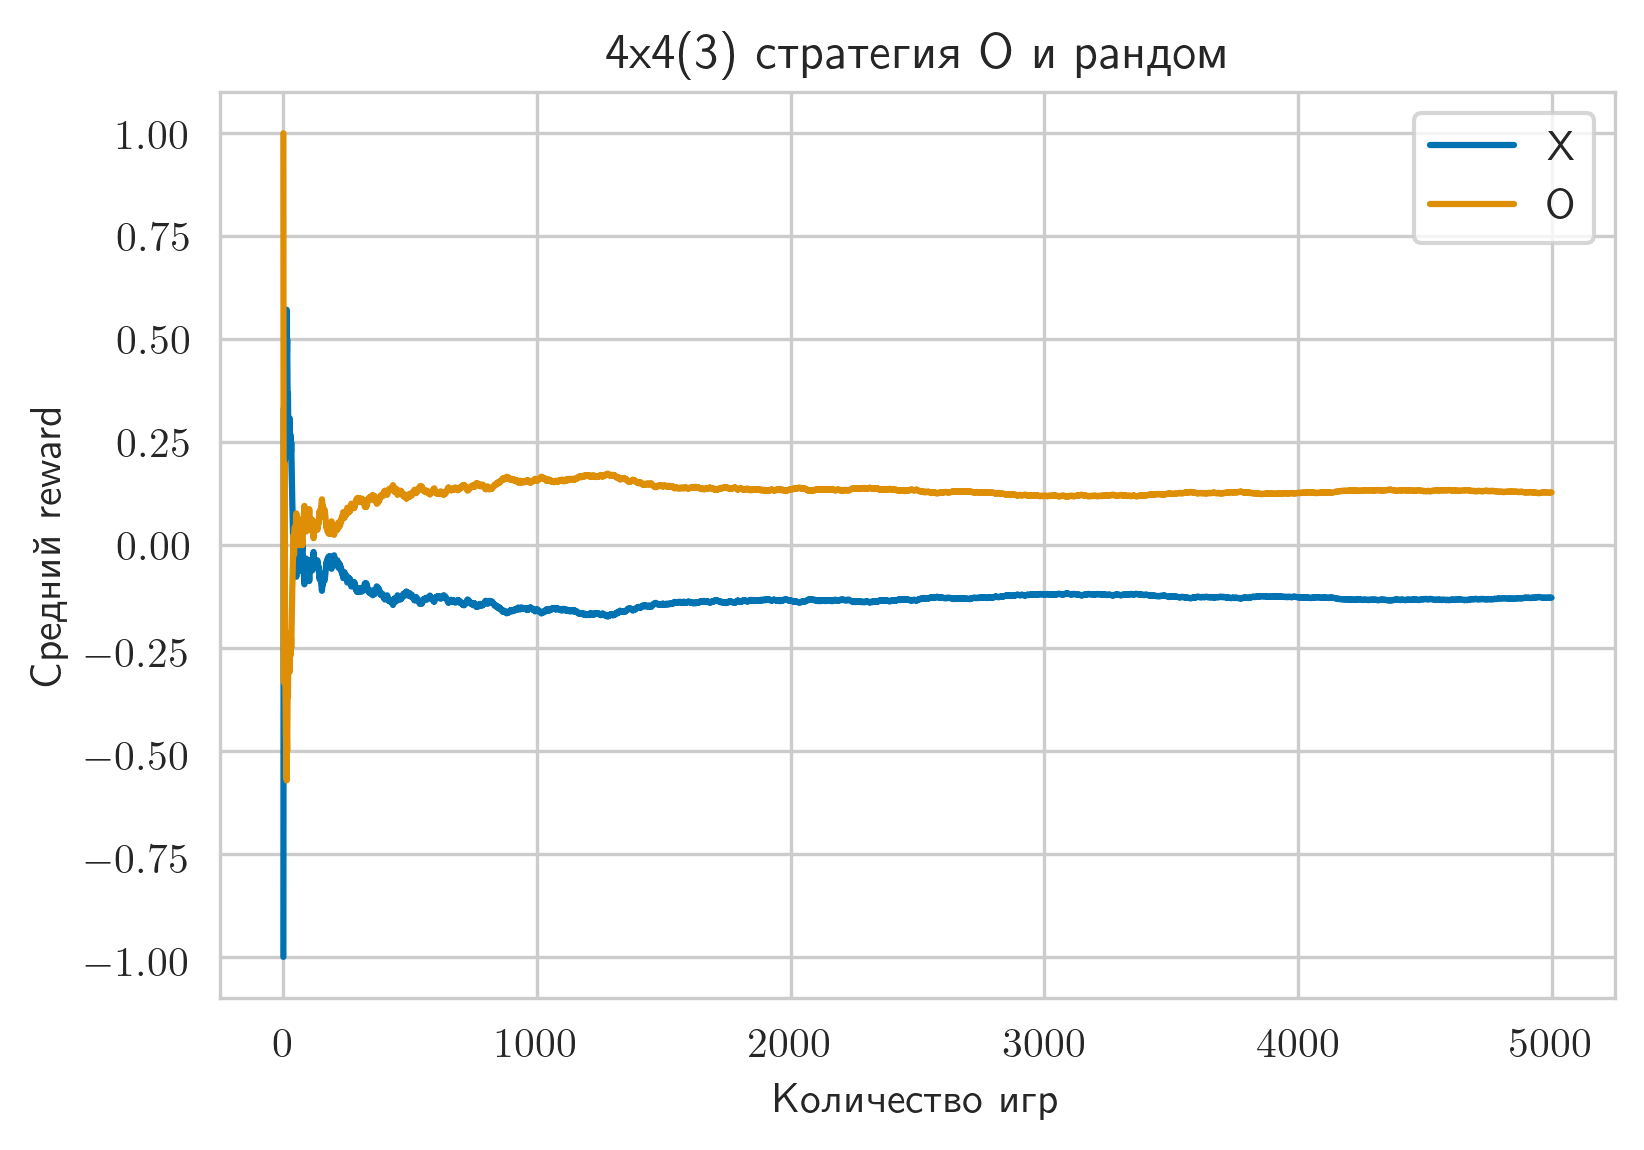

In [82]:
num_episodes = 5000
pi_x.random = True
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(3) стратегия О и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

States length: X - 435188, O - 404353


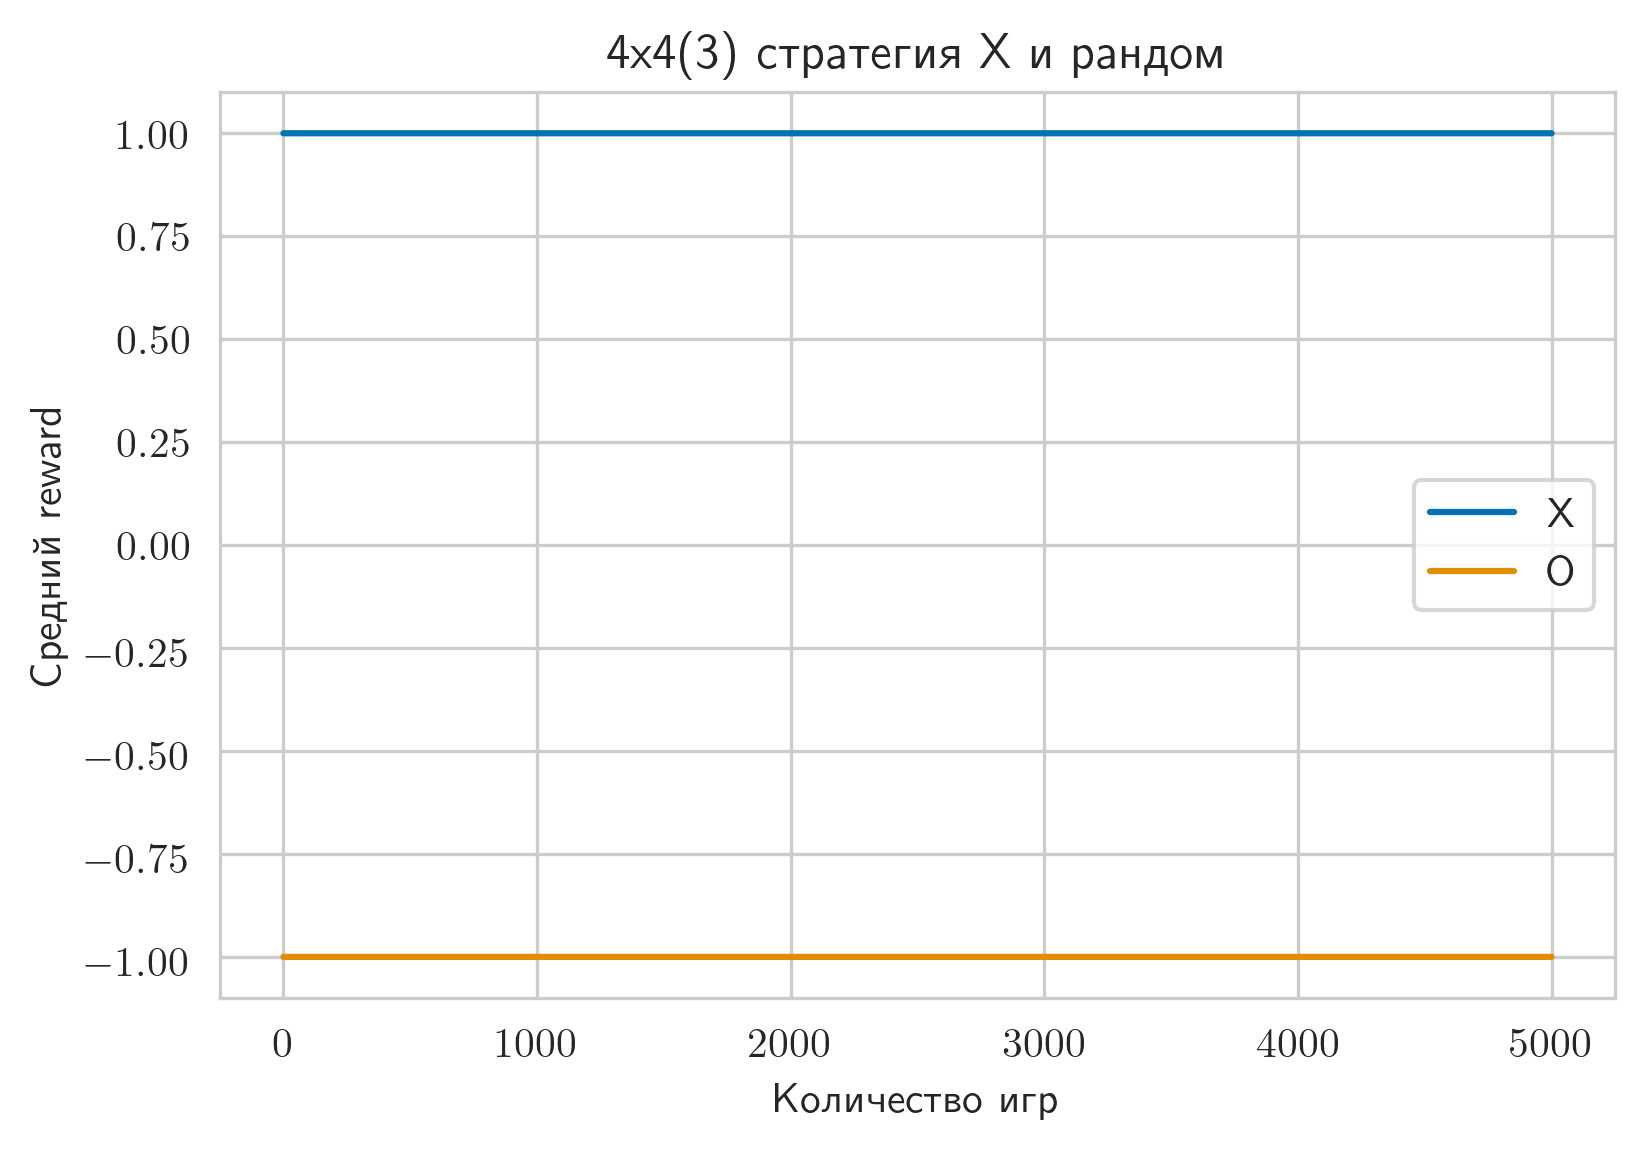

In [83]:
num_episodes = 5000
pi_x.random = False
pi_o.random = True
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(3) стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

### 4x4 4 в ряд

In [85]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

In [86]:
num_episodes = 500000
gamma = 1
alpha = 0.9
epsilon = 0.1

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
rewards_x, rewards_o, pi_x, pi_o = Q_learning_episodes(env, num_episodes, 
                                                       alpha=alpha, epsilon=epsilon, gamma=gamma)



/Users/donfa1con/.virtualenvs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


States length: X - 1122155, O - 1087014


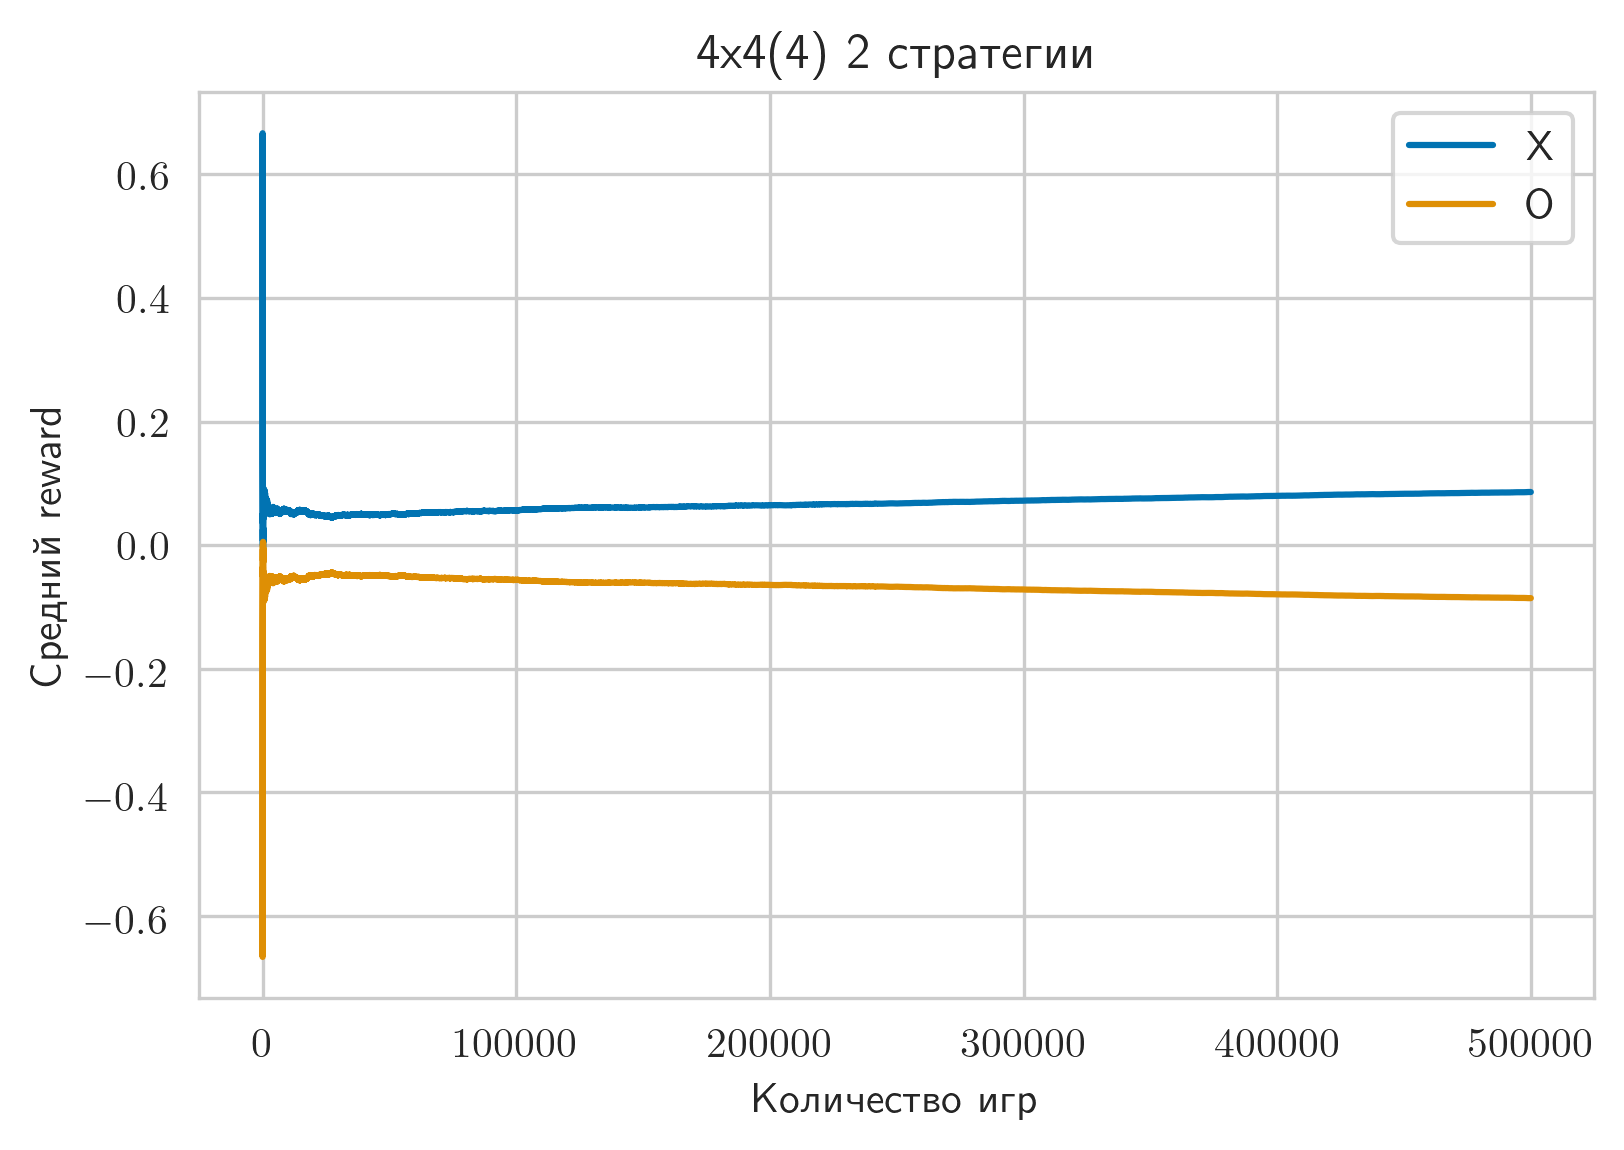

In [87]:
print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(4) 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

States length: X - 1122155, O - 1087015


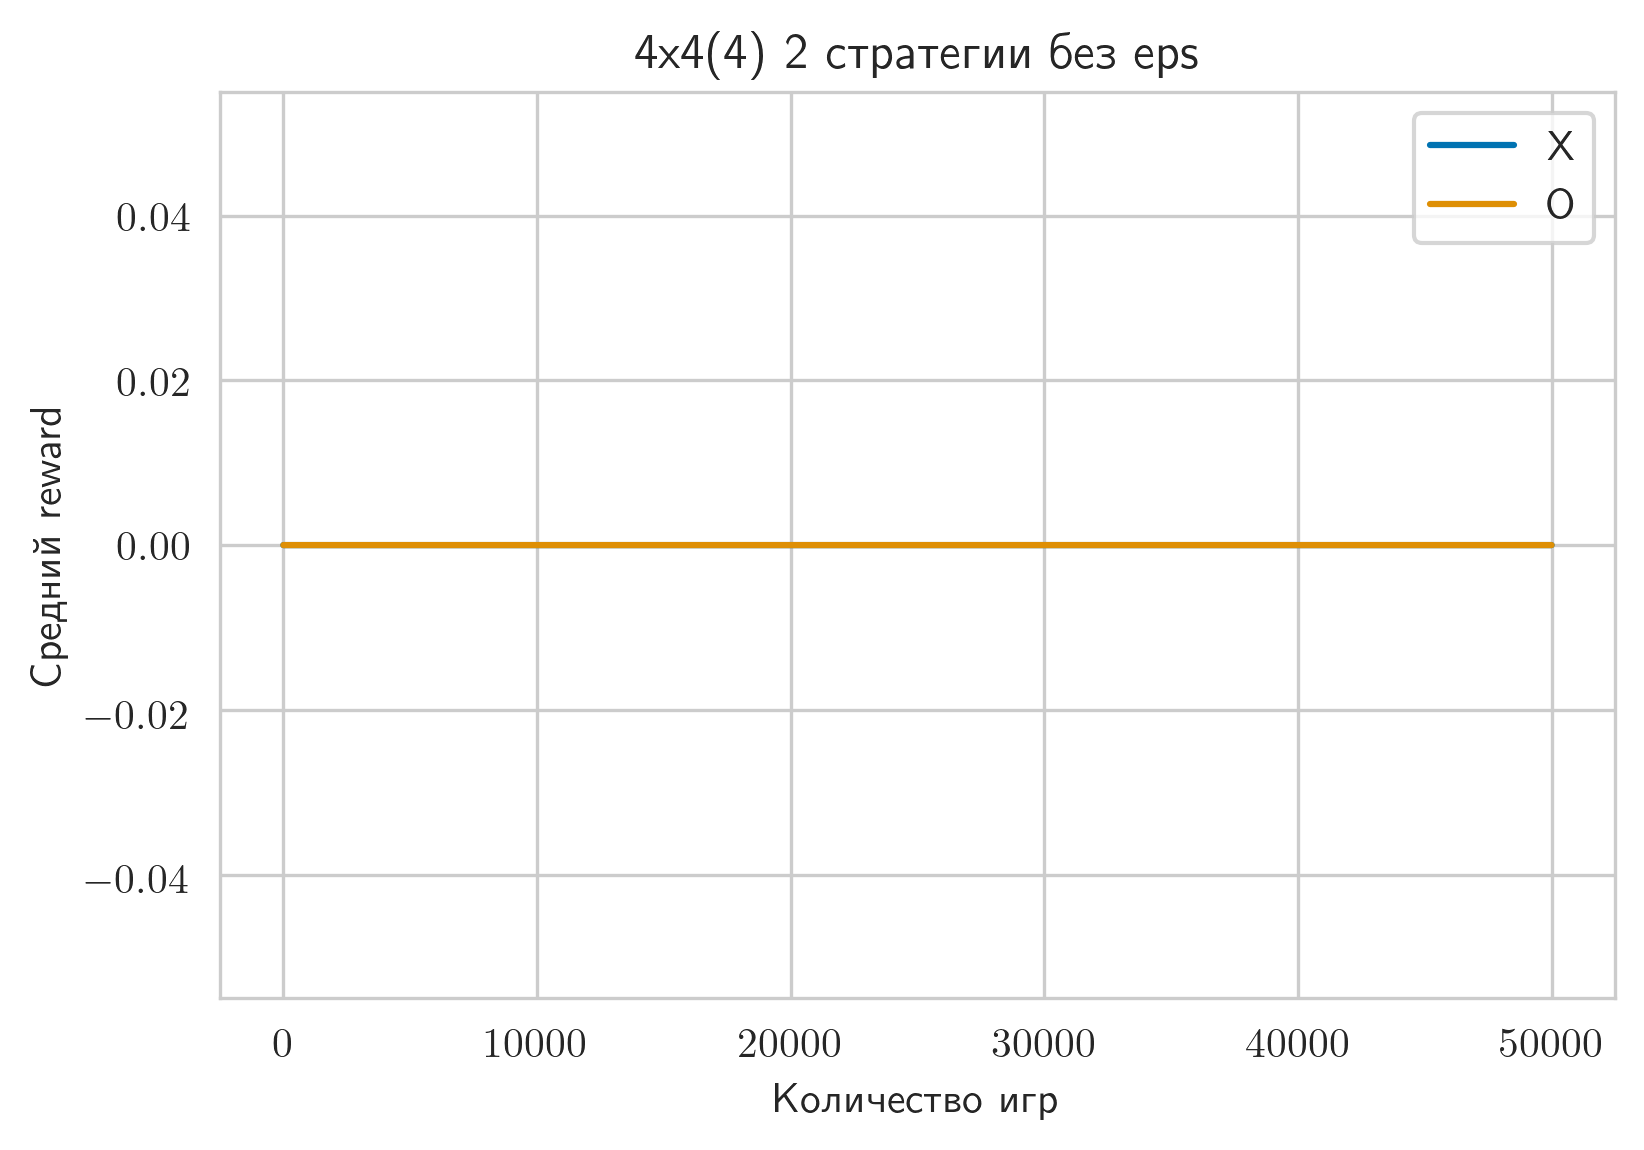

In [89]:
num_episodes = 50000
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(4) 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

States length: X - 1141373, O - 1110902


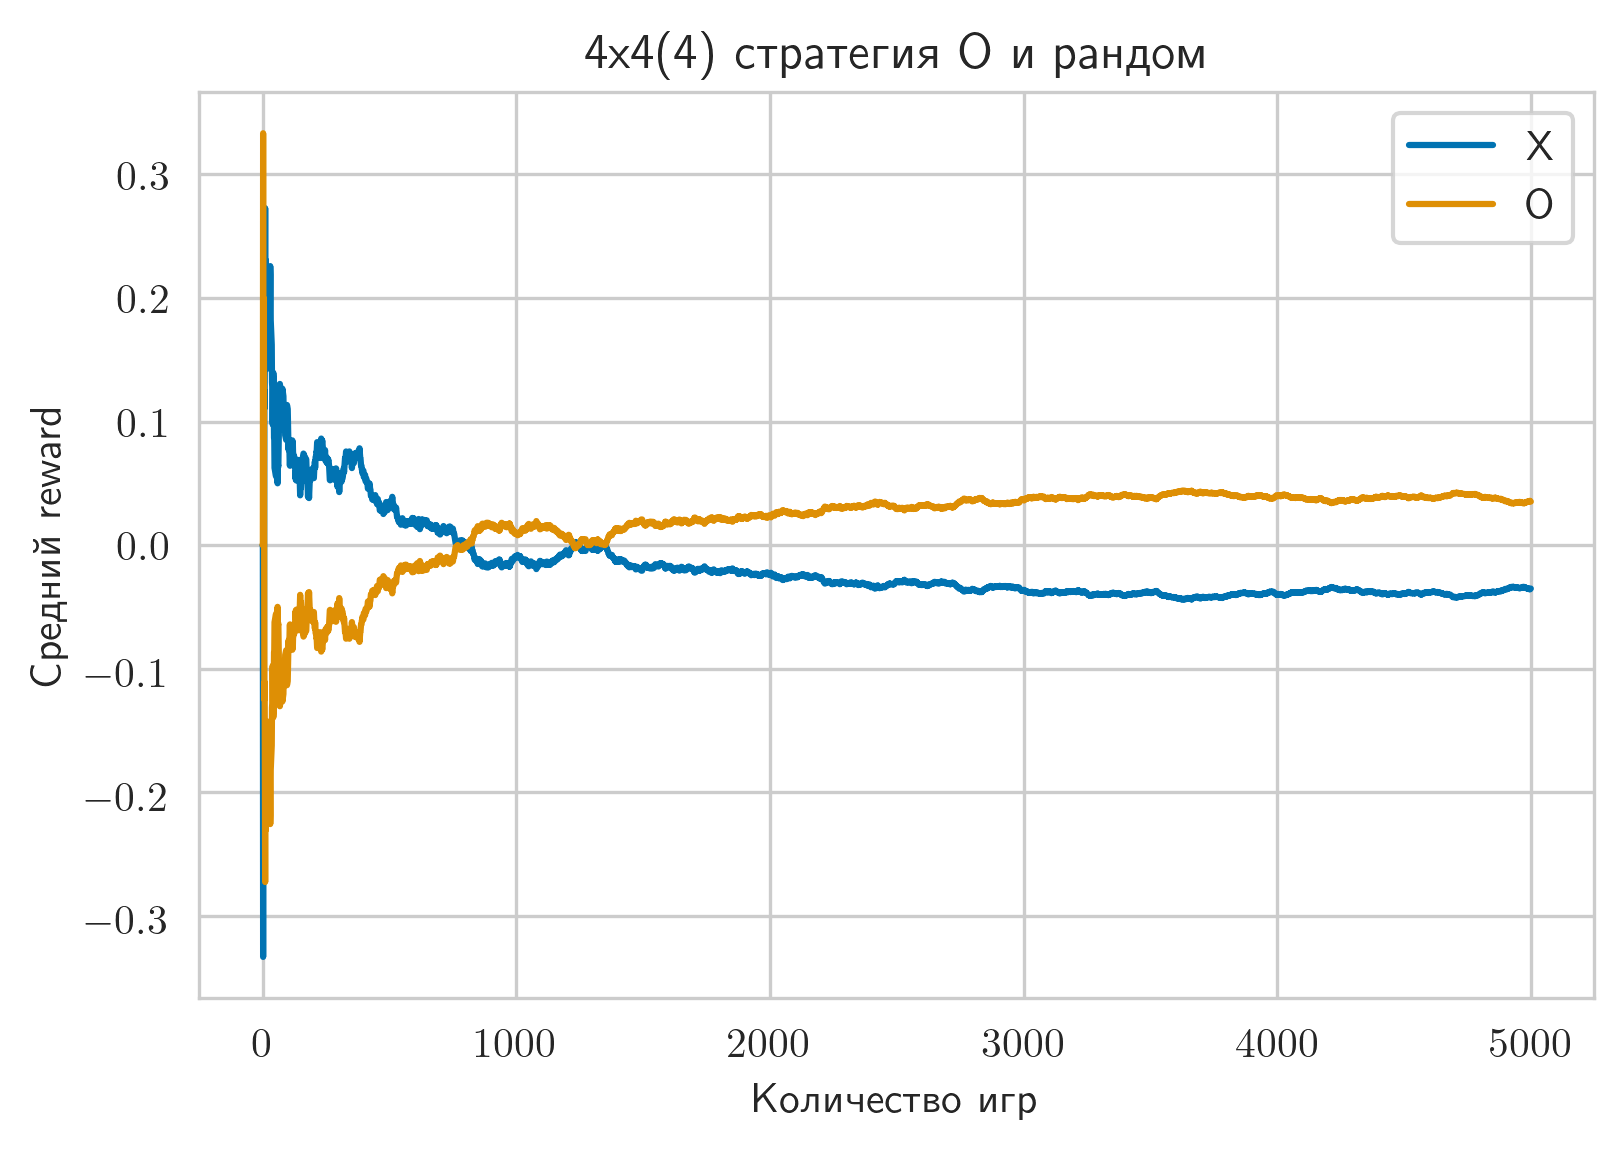

In [91]:
num_episodes = 5000
pi_x.random = True
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(4) стратегия О и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

States length: X - 1152604, O - 1119350


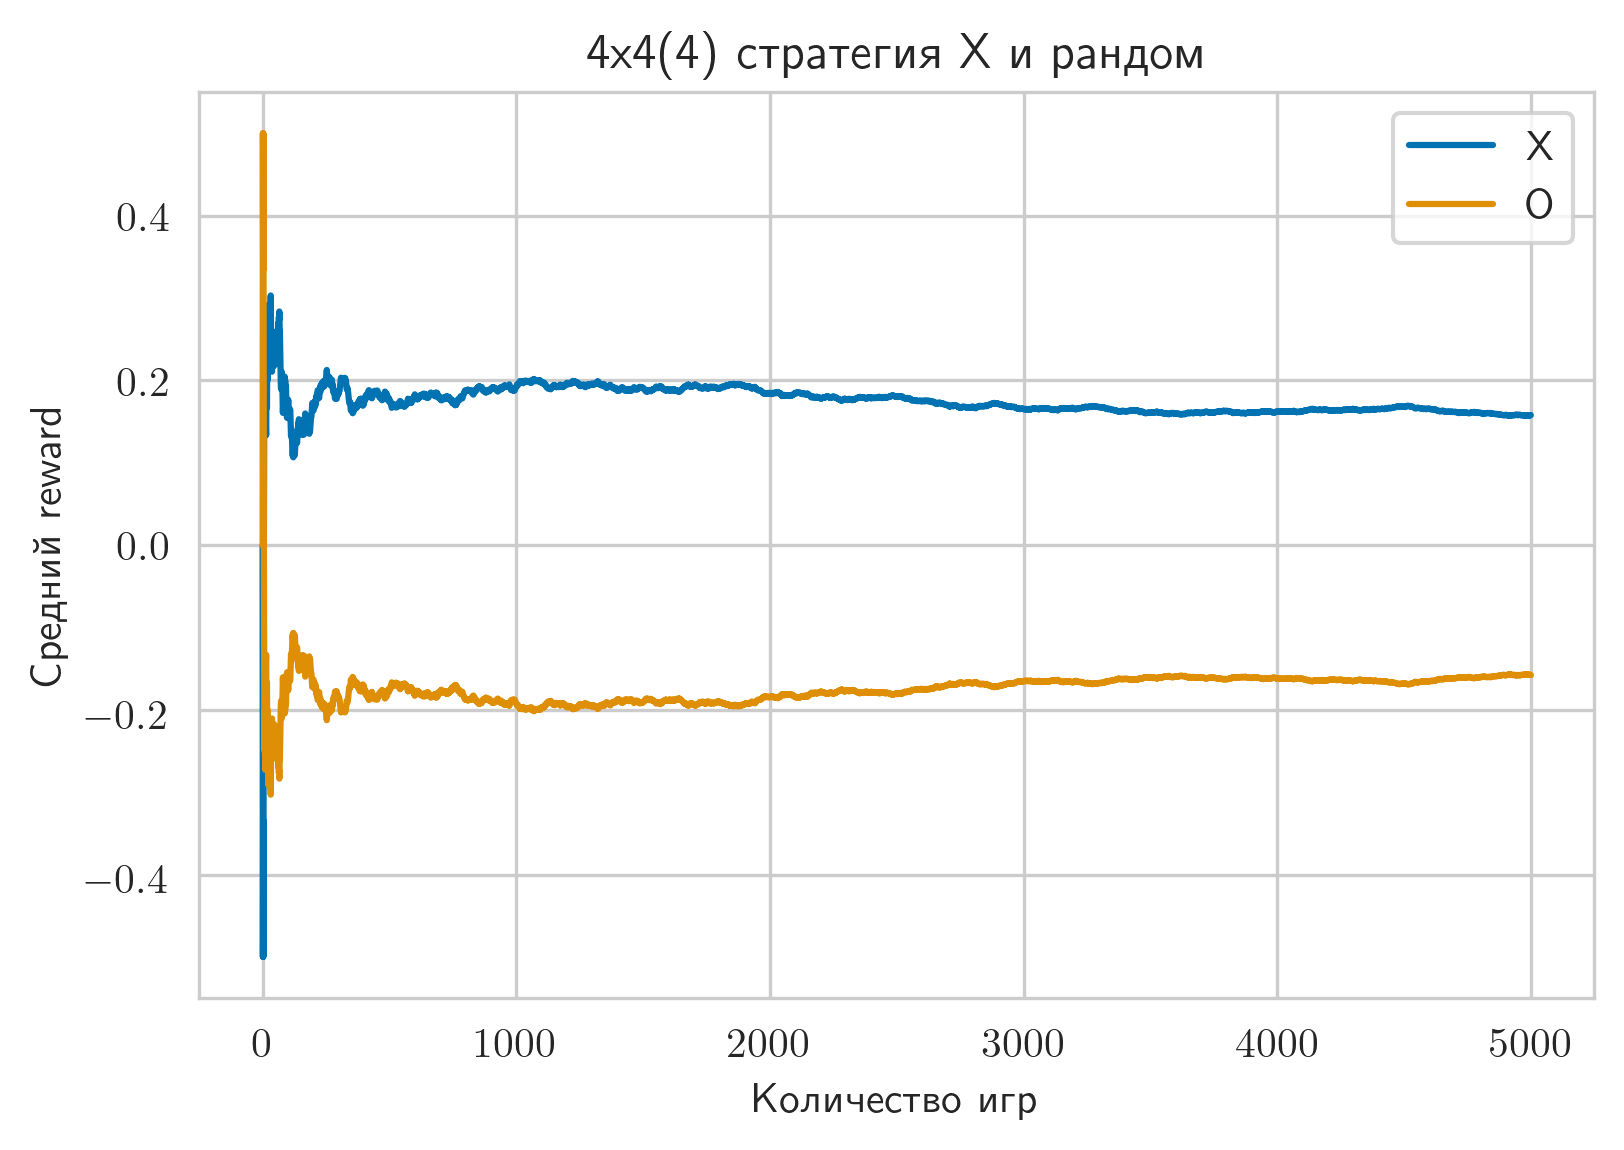

In [92]:
num_episodes = 5000
pi_x.random = False
pi_o.random = True
rewards_x, rewards_o = run_best_Q_strategy(env, pi_x, pi_o, num_episodes)

print(f'States length: X - {len(pi_x.Q)}, O - {len(pi_o.Q)}')
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4(4) стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

## DQN

In [148]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [681]:
class Network(nn.Module):
    def __init__(self, channels=8, linear=8, actions=9):
        nn.Module.__init__(self)
        self.l1 = nn.Conv2d(1, channels, 3)
        self.flatten = nn.Flatten()
        self.l2 = nn.Linear(linear, actions)

    def forward(self, x):
        x = self.flatten(F.relu(self.l1(x)))
        x = self.l2(x)
        return x

In [789]:
class TicTacToeDQN():
    def __init__(self, num_episodes, gamma=1, batch_size=32, channels=16, linear=16, actions=9):
        self.model_x = Network(channels, linear, actions)
        self.model_o = Network(channels, linear, actions)
        self.memory_x = ReplayMemory(64)
        self.memory_o = ReplayMemory(64)
        self.optimizer_x = optim.Adam(self.model_x.parameters(), 0.001)
        self.optimizer_o = optim.Adam(self.model_o.parameters(), 0.001)
        self.steps_done = 0
        self.rewards_x = []
        self.rewards_o = []
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, num_episodes - num_episodes // 10
        self.num_step = 0
        self.losses_x = []
        self.losses_o = []
        actions_space = list(itertools.product(range(N_ROWS), range(N_COLS)))
        self.actions_space = dict(zip(actions_space, range(len(actions_space))))
        self.rev_actions_space = dict(zip(range(len(actions_space)), actions_space))
        self.num_episodes = num_episodes

    def select_greedy_action(self, state, model):
        return model(state[None]).data.max(1)[1].view(1, 1)

    def select_action(self, state, actions, model):
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step  // 2 / self.eps_decay)
        if random.random() > eps_threshold:
            return self.select_greedy_action(state, model)
        return torch.tensor([[self.actions_space[tuple(random.choice(actions))]]], dtype=torch.int64)

    def run_episodes(self, env):
        def init(env):
            env.reset()
            a = env.getState()[1]
            s = torch.tensor(env.board, dtype=torch.float32)[None]
            with torch.no_grad():
                return s, self.select_action(s, a, self.model_x), None, None
        
        for _ in tqdm.notebook.tqdm(range(self.num_episodes)):
            s_x, a_x, s_o, a_o = init(env)
            while True:
                state, reward, done, info = env.step(self.rev_actions_space[a_x.numpy()[0][0]]
                                                     if env.curTurn == 1 
                                                     else self.rev_actions_space[a_o.numpy()[0][0]])
                if done:
                    if reward == -10:
                        if env.curTurn == -1:
                            self.rewards_x.append(reward)
                            transition = (s_x, a_x, s_x, torch.tensor([reward], dtype=torch.float32),
                                          torch.tensor([done], dtype=torch.float32))
                            self.memory_x.store(transition)
                            self.learn(self.model_x, self.optimizer_x, self.memory_x, self.losses_x)
                        else:
                            self.rewards_o.append(reward)
                            transition = (s_o, a_o, s_o, torch.tensor([reward], dtype=torch.float32),
                                          torch.tensor([done], dtype=torch.float32))
                            self.memory_o.store(transition)
                            self.learn(self.model_o, self.optimizer_o, self.memory_o, self.losses_o)
                    else:
                        self.rewards_x.append(reward)
                        self.rewards_o.append(-reward)
                        transition = (s_x, a_x, s_x, torch.tensor([reward], dtype=torch.float32), 
                                      torch.tensor([done], dtype=torch.float32))
                        self.memory_x.store(transition)
                        transition = (s_o, a_o, s_o, torch.tensor([-reward], dtype=torch.float32),
                                      torch.tensor([done], dtype=torch.float32))
                        self.memory_o.store(transition)
                        self.learn(self.model_x, self.optimizer_x, self.memory_x, self.losses_x)
                        self.learn(self.model_o, self.optimizer_o, self.memory_o, self.losses_o)
                else:
                    if env.curTurn == 1:
                        s_x_prime = torch.tensor(env.board, dtype=torch.float32)[None]
                        a_x_prime = self.select_action(s_x_prime, state[1], self.model_x)
                        
                        transition = (s_x, a_x, s_x_prime, torch.tensor([reward], dtype=torch.float32),
                                      torch.tensor([done], dtype=torch.float32))
                        self.memory_x.store(transition)
                        self.learn(self.model_x, self.optimizer_x, self.memory_x, self.losses_x)
                        s_x, a_x = s_x_prime, a_x_prime
                    else:
                        if s_o is None:
                            s_o = torch.tensor(env.board, dtype=torch.float32)[None]
                            a_o = self.select_action(s_o, state[1], self.model_o)
                        else:
                            s_o_prime = torch.tensor(env.board, dtype=torch.float32)[None]
                            a_o_prime = self.select_action(s_o_prime, state[1], self.model_o)
                            
                            transition = (s_o, a_o, s_o_prime, torch.tensor([reward], dtype=torch.float32),
                                          torch.tensor([done], dtype=torch.float32))
                            self.memory_o.store(transition)
                            self.learn(self.model_o, self.optimizer_o, self.memory_o, self.losses_o)
                            s_o, a_o = s_o_prime, a_o_prime

                if done:
                    s_x, a_x, s_o, a_o = init(env)
                    break

    def learn(self, model, optimizer, memory, losses):
        if len(memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state))
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))
        batch_done = torch.cat(batch_done)
        
        # считаем значения функции Q
        Q = model(batch_state[:, None]).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = model(batch_next_state[:, None]).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)
        Qnext[batch_done == 1] = batch_reward[batch_done == 1]

        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

In [790]:
def run_best_Q_strategy(env, num_episodes, model_x=None, model_o=None):
    def get_s_a(state, actions, model):
        with torch.no_grad():
            s, a = state, model(torch.tensor(env.board, dtype=torch.float32)[None, None]).data.numpy()[0] if model else random.choice(actions)
        if model:
            idx = list(np.argsort(a))
            while dqn.rev_actions_space[idx[-1]] not in map(tuple, actions):
                idx.pop()
            return s, tuple(dqn.rev_actions_space[idx[-1]])
        return s, tuple(random.choice(actions))

    def init(env):
        env.reset()
        s, a = env.getState()[:2]
        return get_s_a(s, a, model_x)
    
    rewards_x = []
    rewards_o = []
    
    for _ in range(num_episodes):
        s, a = init(env)
        while True:
            state, reward, done, info = env.step(a)
            if done:
                rewards_x.append(reward)
                rewards_o.append(-reward)
                s, a = init(env)
                break
            else:
                if env.curTurn == 1:
                    s, a = get_s_a(*state[:2], model_x)
                else:
                    s, a = get_s_a(*state[:2], model_o)
    return (np.cumsum(rewards_x) / (np.arange(len(rewards_x)) + 1), 
            np.cumsum(rewards_o) / (np.arange(len(rewards_o)) + 1))

### 3x3

In [791]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
num_episodes = 10000
dqn = TicTacToeDQN(num_episodes, batch_size=32)

In [792]:
dqn.run_episodes(env)

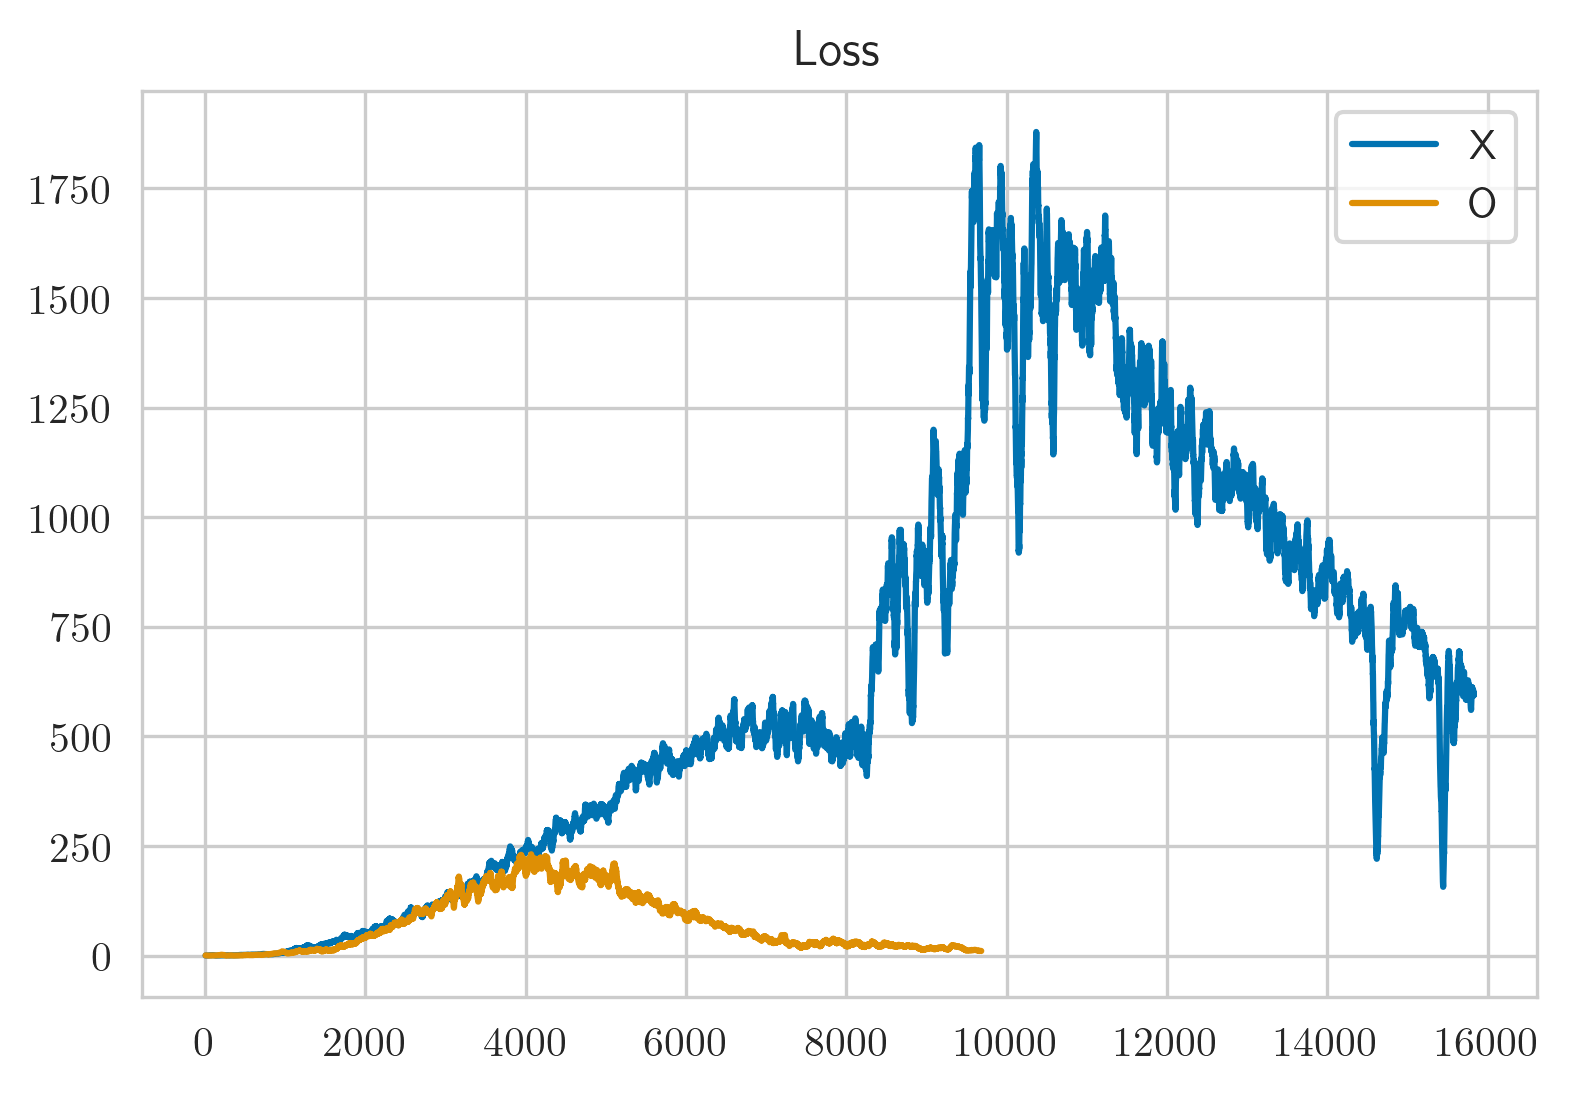

In [793]:
plt.plot(pd.Series(dqn.losses_x).rolling(10).mean(), label='X')
plt.plot(pd.Series(dqn.losses_o).rolling(10).mean(), label='O')
plt.legend()
plt.title('Loss');

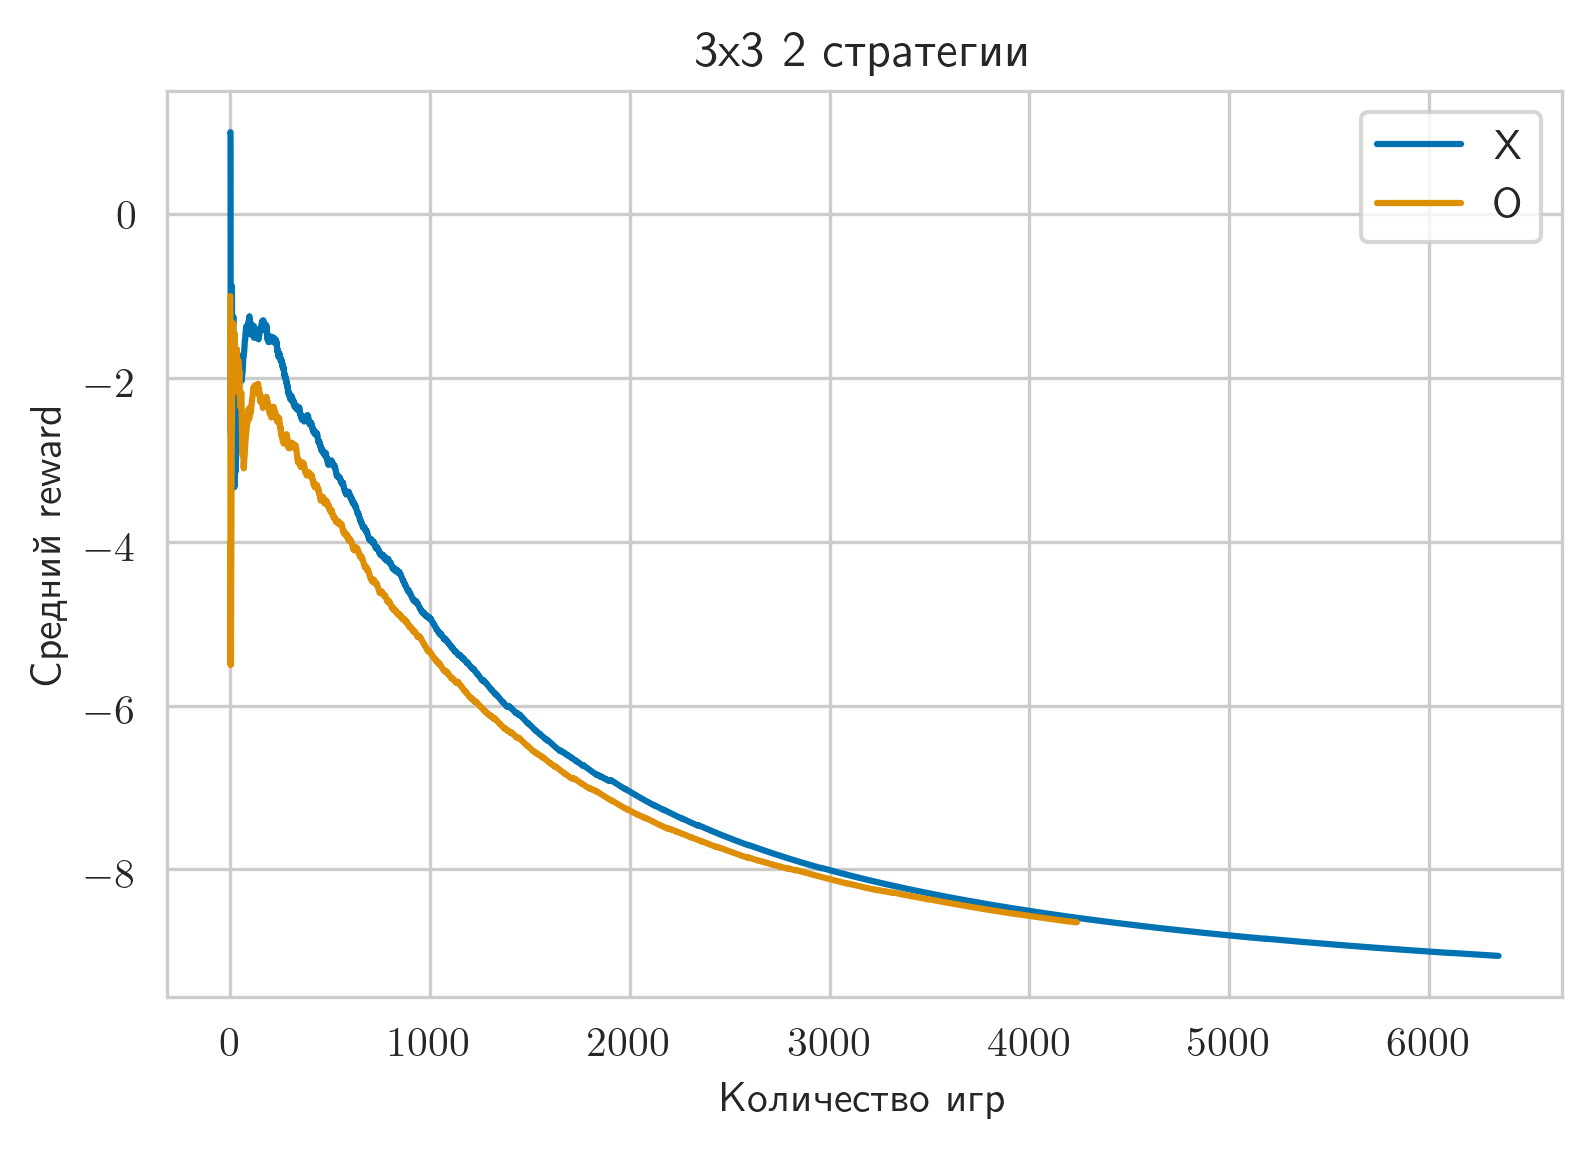

In [794]:
plt.plot(np.cumsum(dqn.rewards_x) / (np.arange(len(dqn.rewards_x)) + 1), label='X')
plt.plot(np.cumsum(dqn.rewards_o) / (np.arange(len(dqn.rewards_o)) + 1), label='O')
plt.title('3x3 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

In [795]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, dqn.model_o)

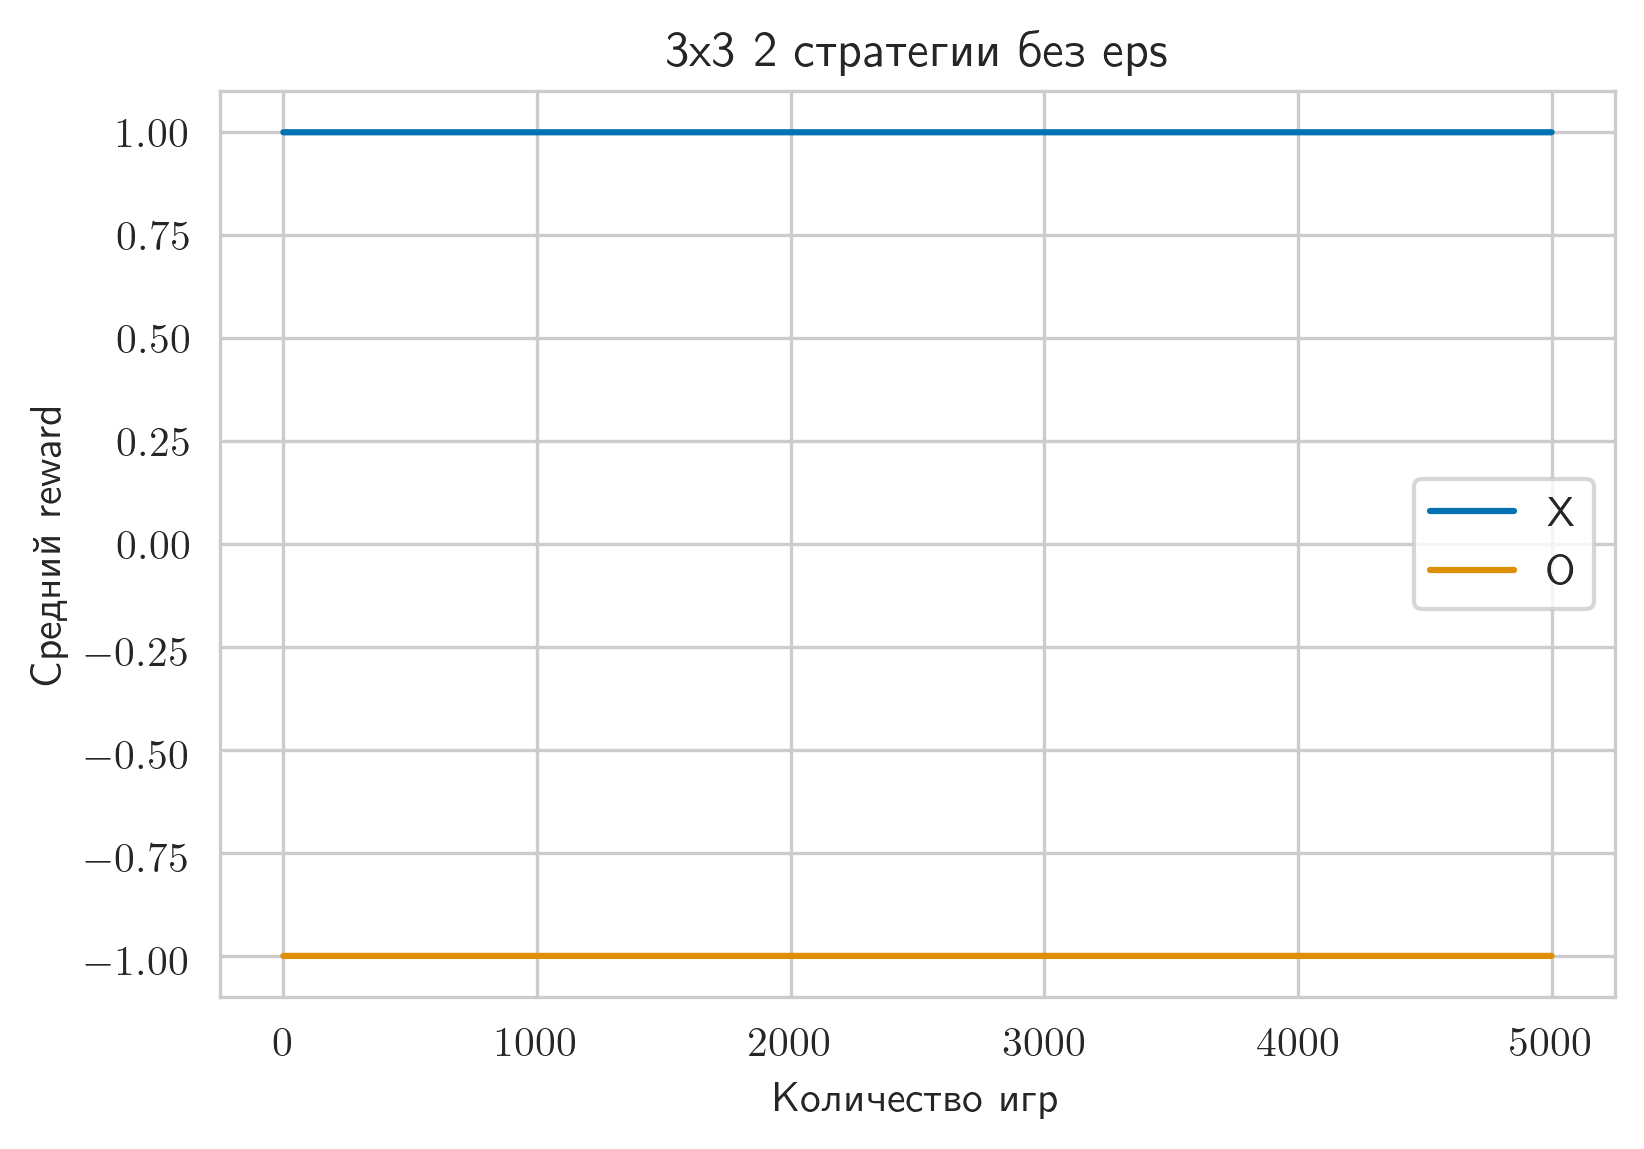

In [796]:
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

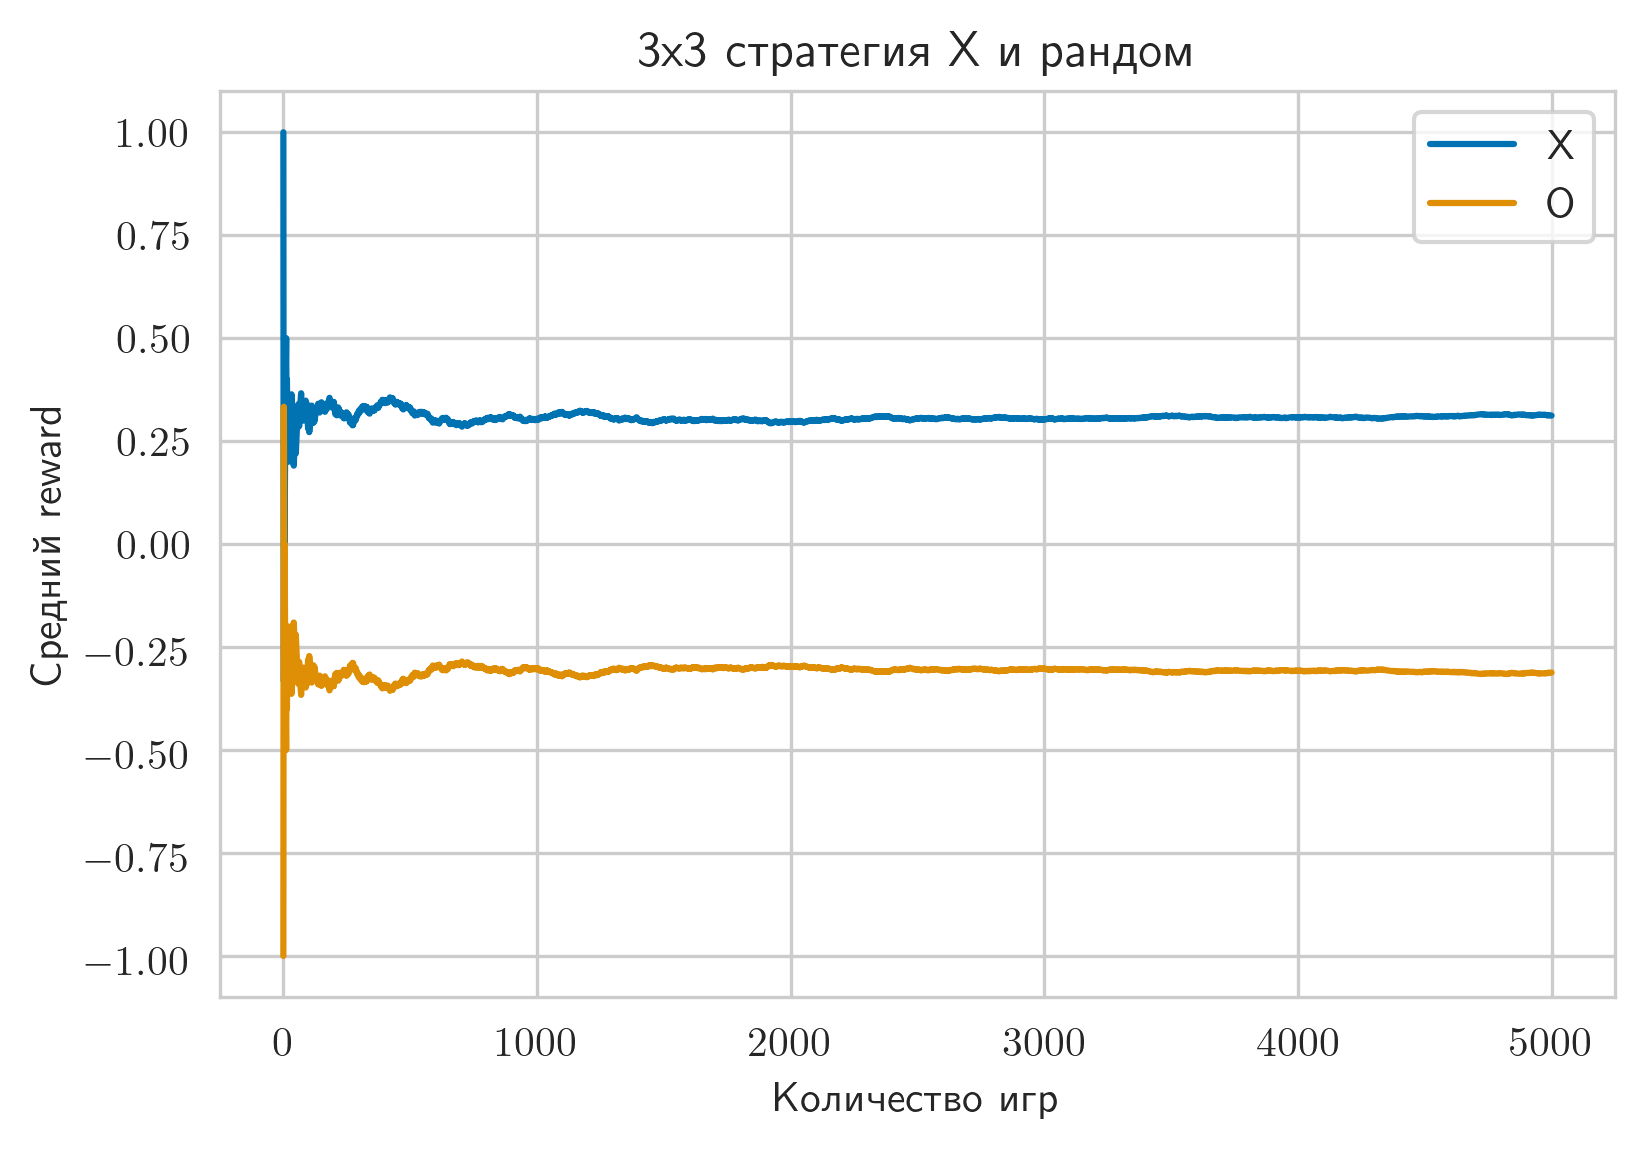

In [797]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, None)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

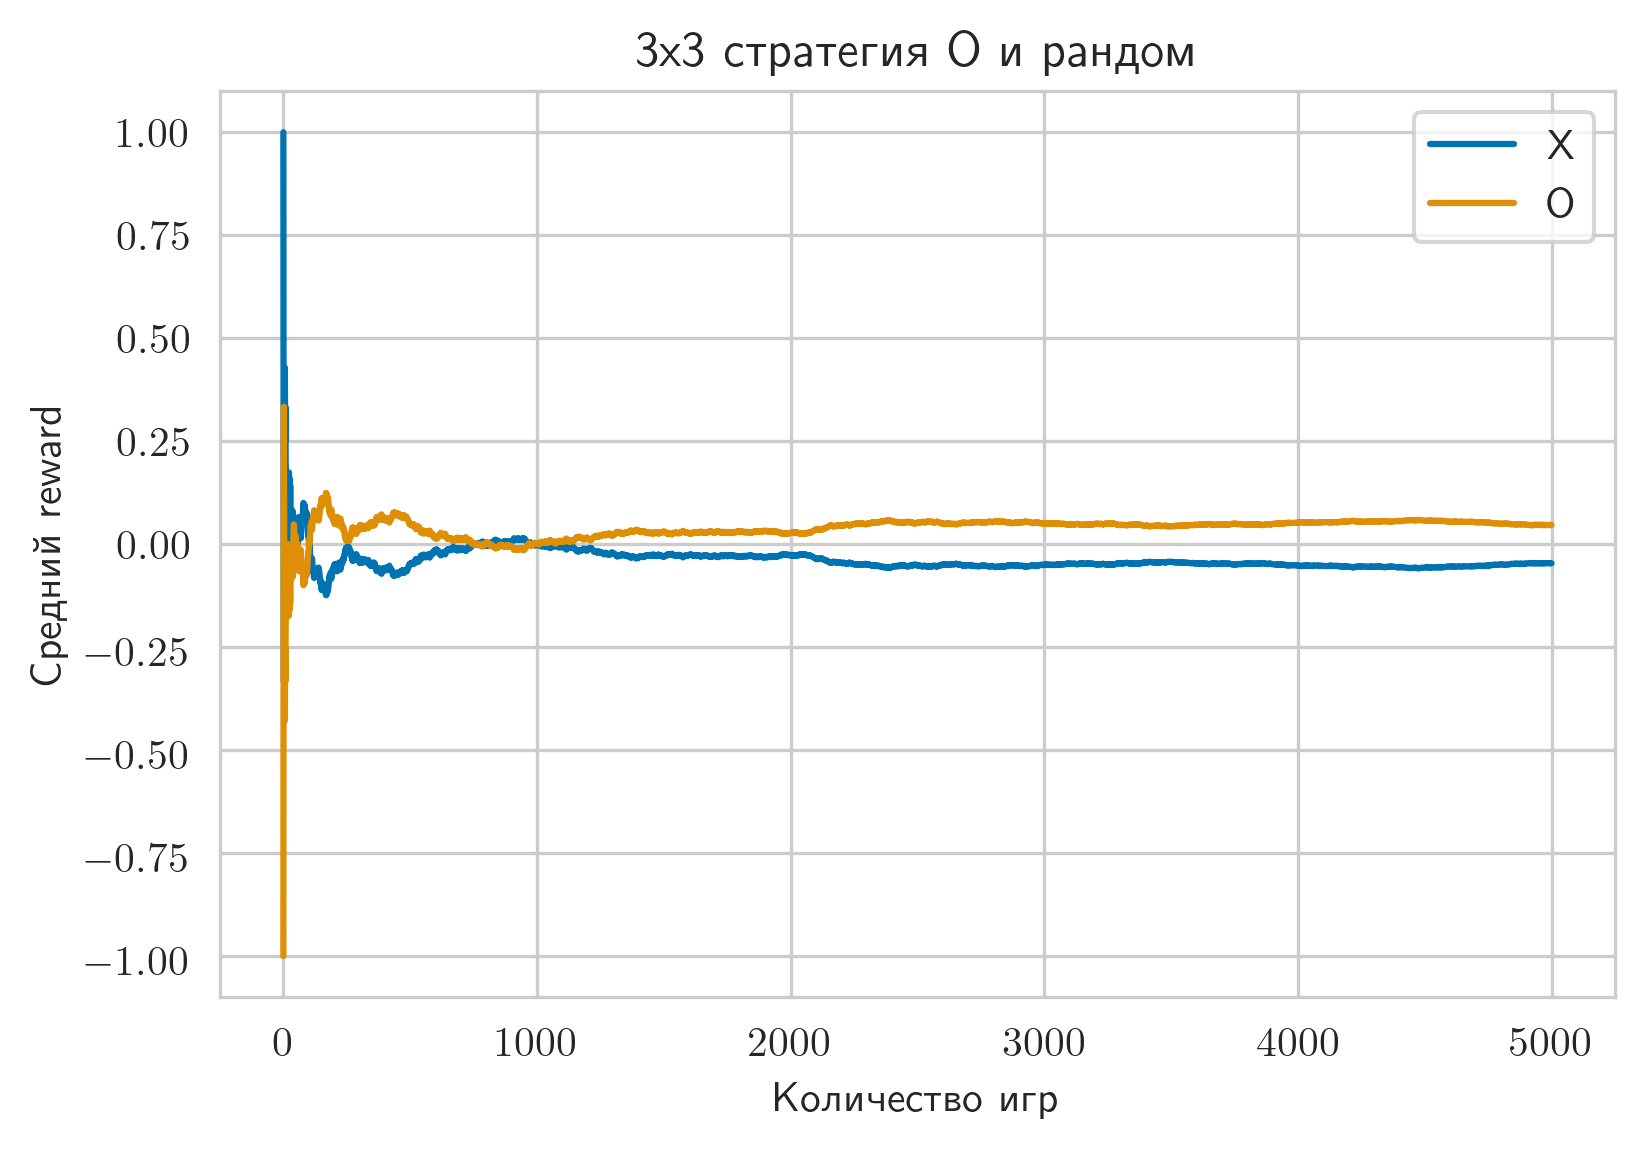

In [798]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, None, dqn.model_o)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 стратегия O и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

### 4x4 4 в ряд

In [799]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
num_episodes = 20000
dqn = TicTacToeDQN(num_episodes, batch_size=32, linear=64, actions=16)

In [800]:
dqn.run_episodes(env)

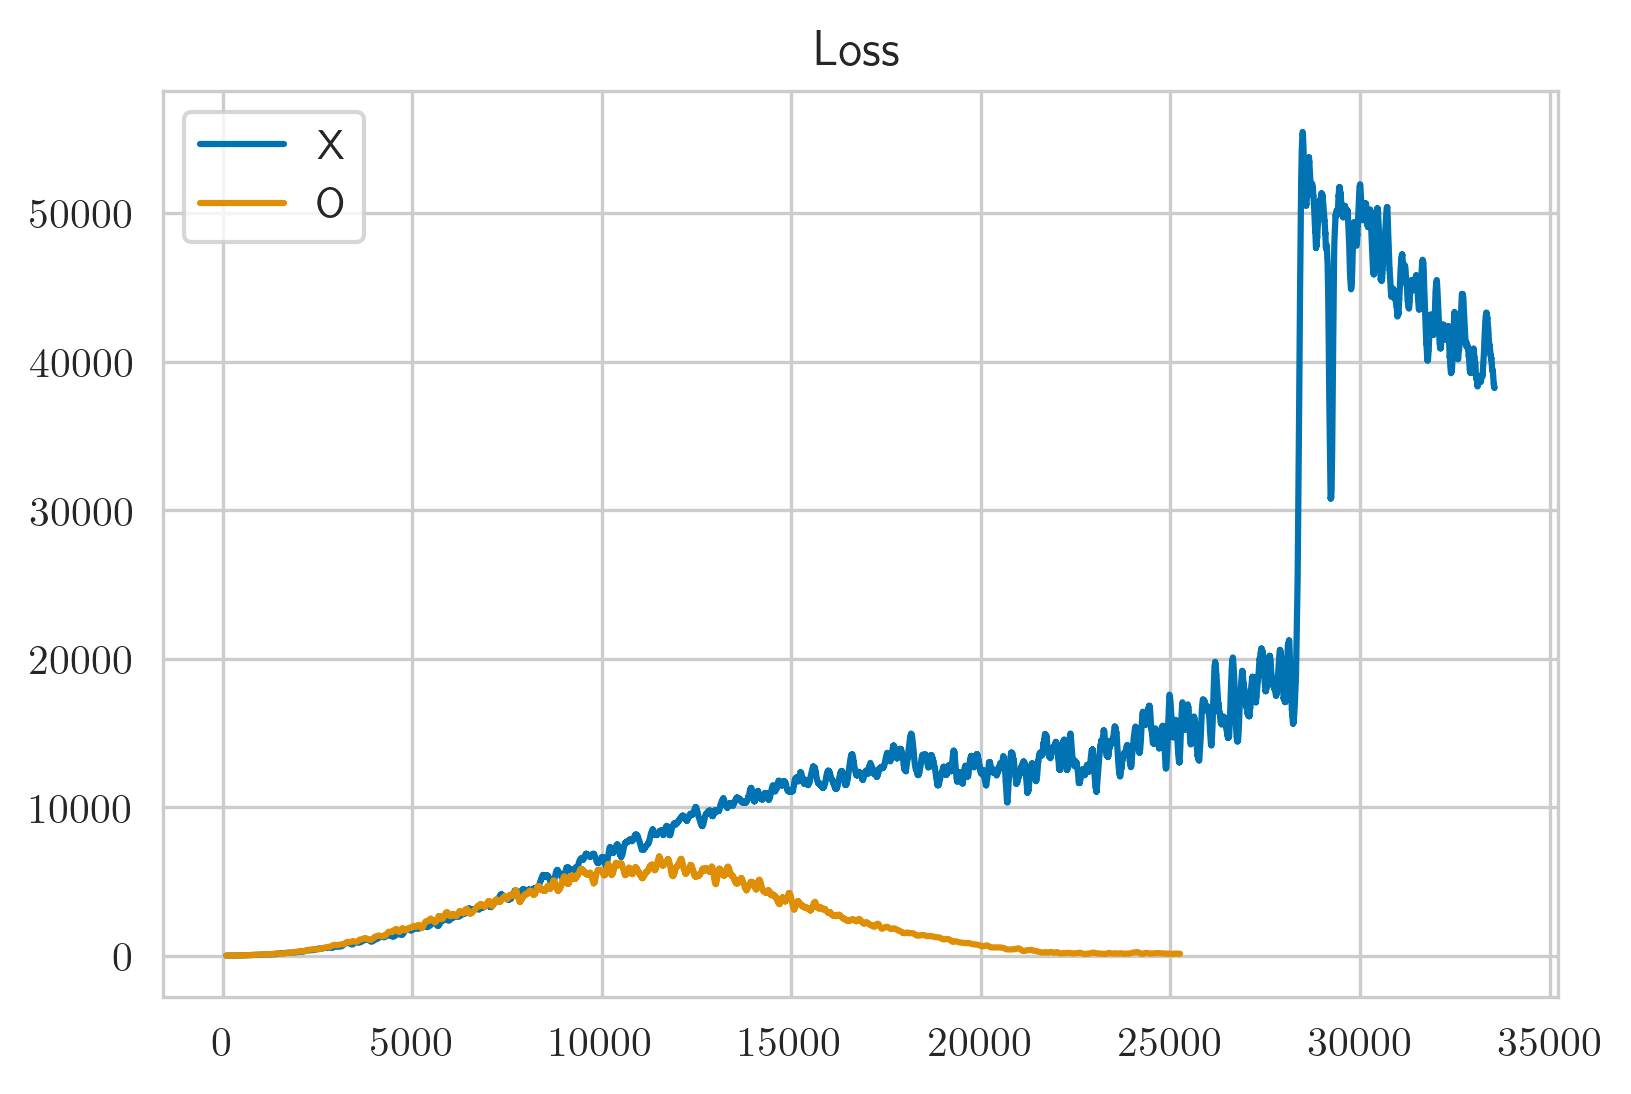

In [801]:
plt.plot(pd.Series(dqn.losses_x).rolling(100).mean(), label='X')
plt.plot(pd.Series(dqn.losses_o).rolling(100).mean(), label='O')
plt.legend()
plt.title('Loss');

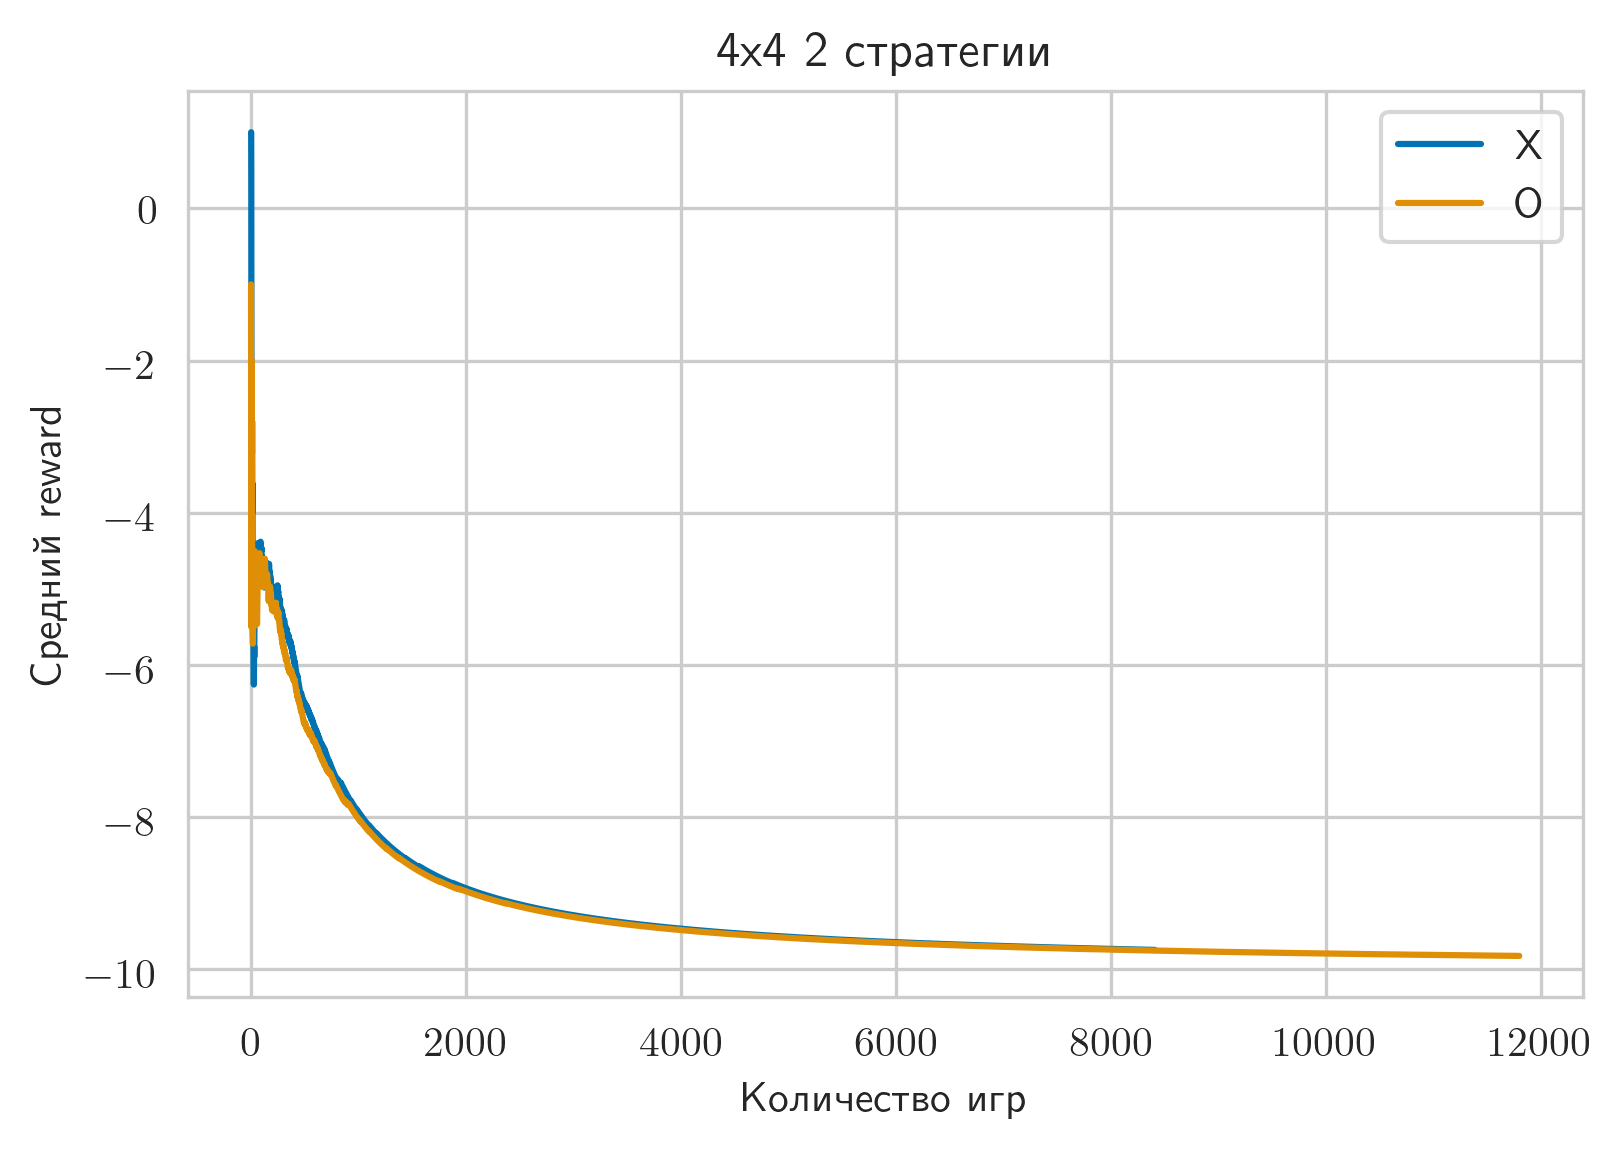

In [802]:
plt.plot(np.cumsum(dqn.rewards_x) / (np.arange(len(dqn.rewards_x)) + 1), label='X')
plt.plot(np.cumsum(dqn.rewards_o) / (np.arange(len(dqn.rewards_o)) + 1), label='O')
plt.title('4x4 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

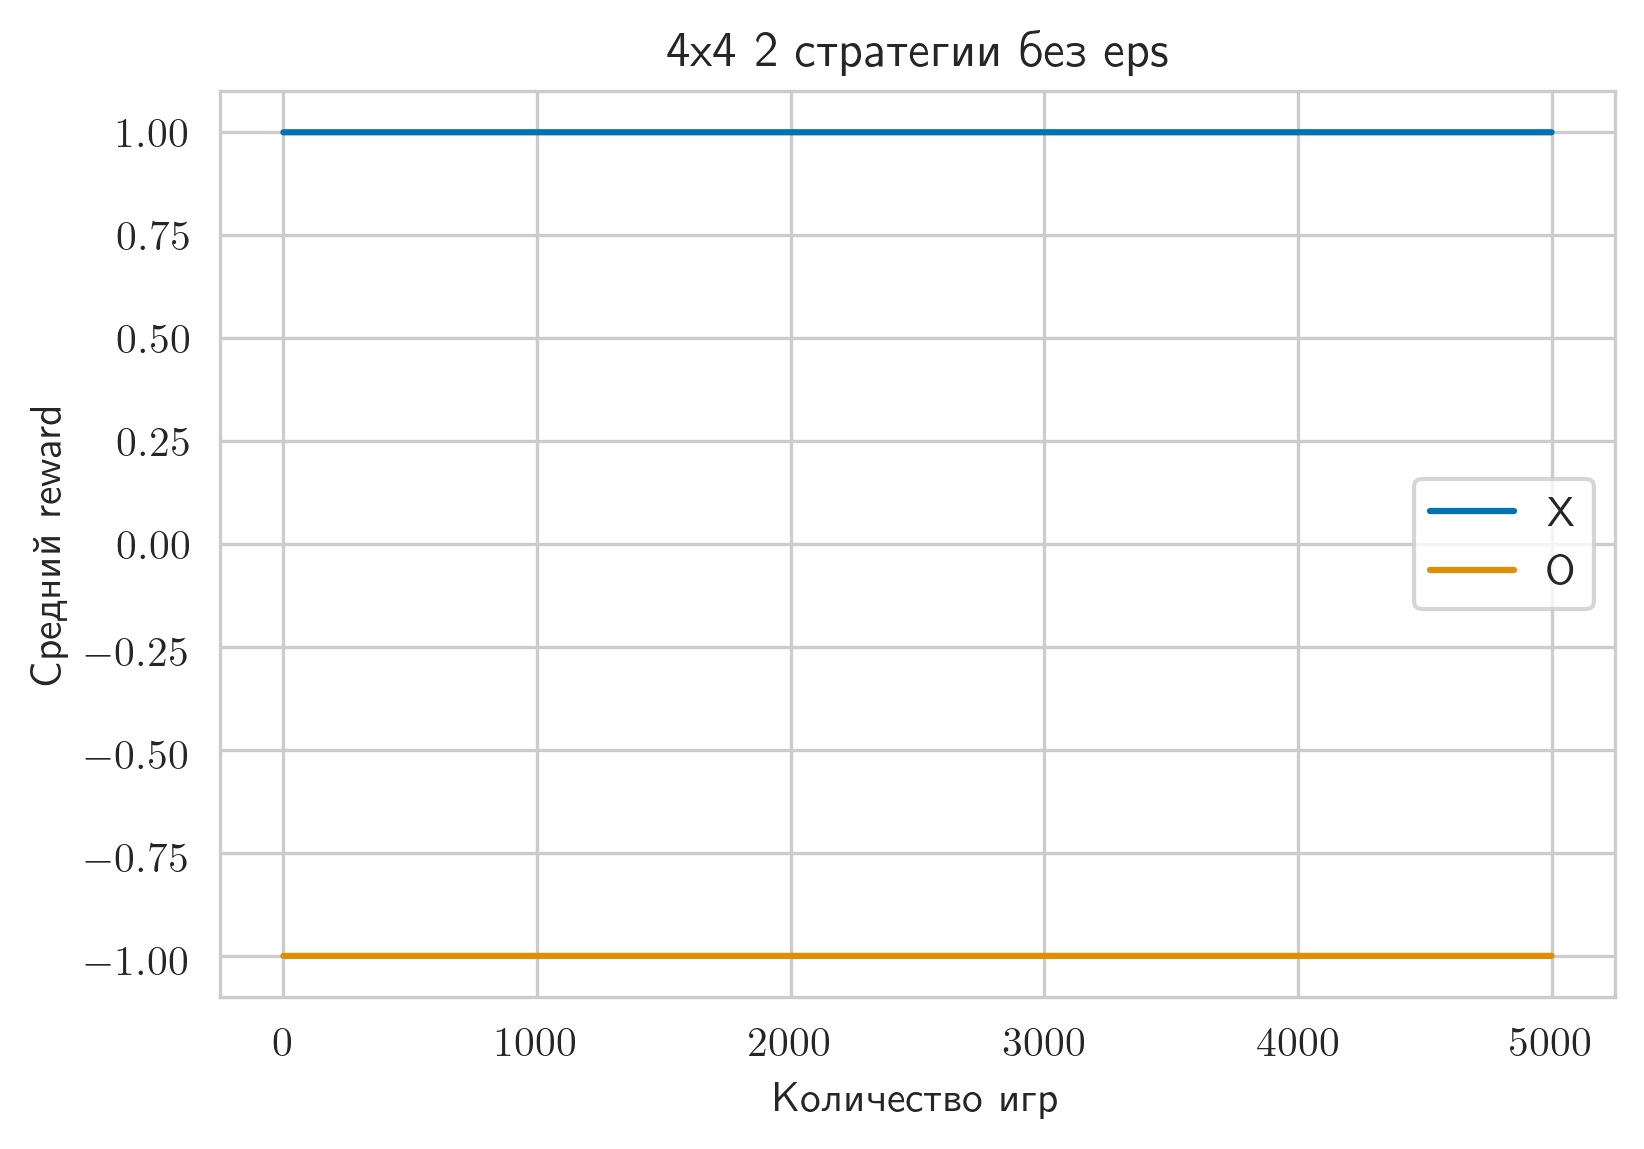

In [804]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, dqn.model_o)
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

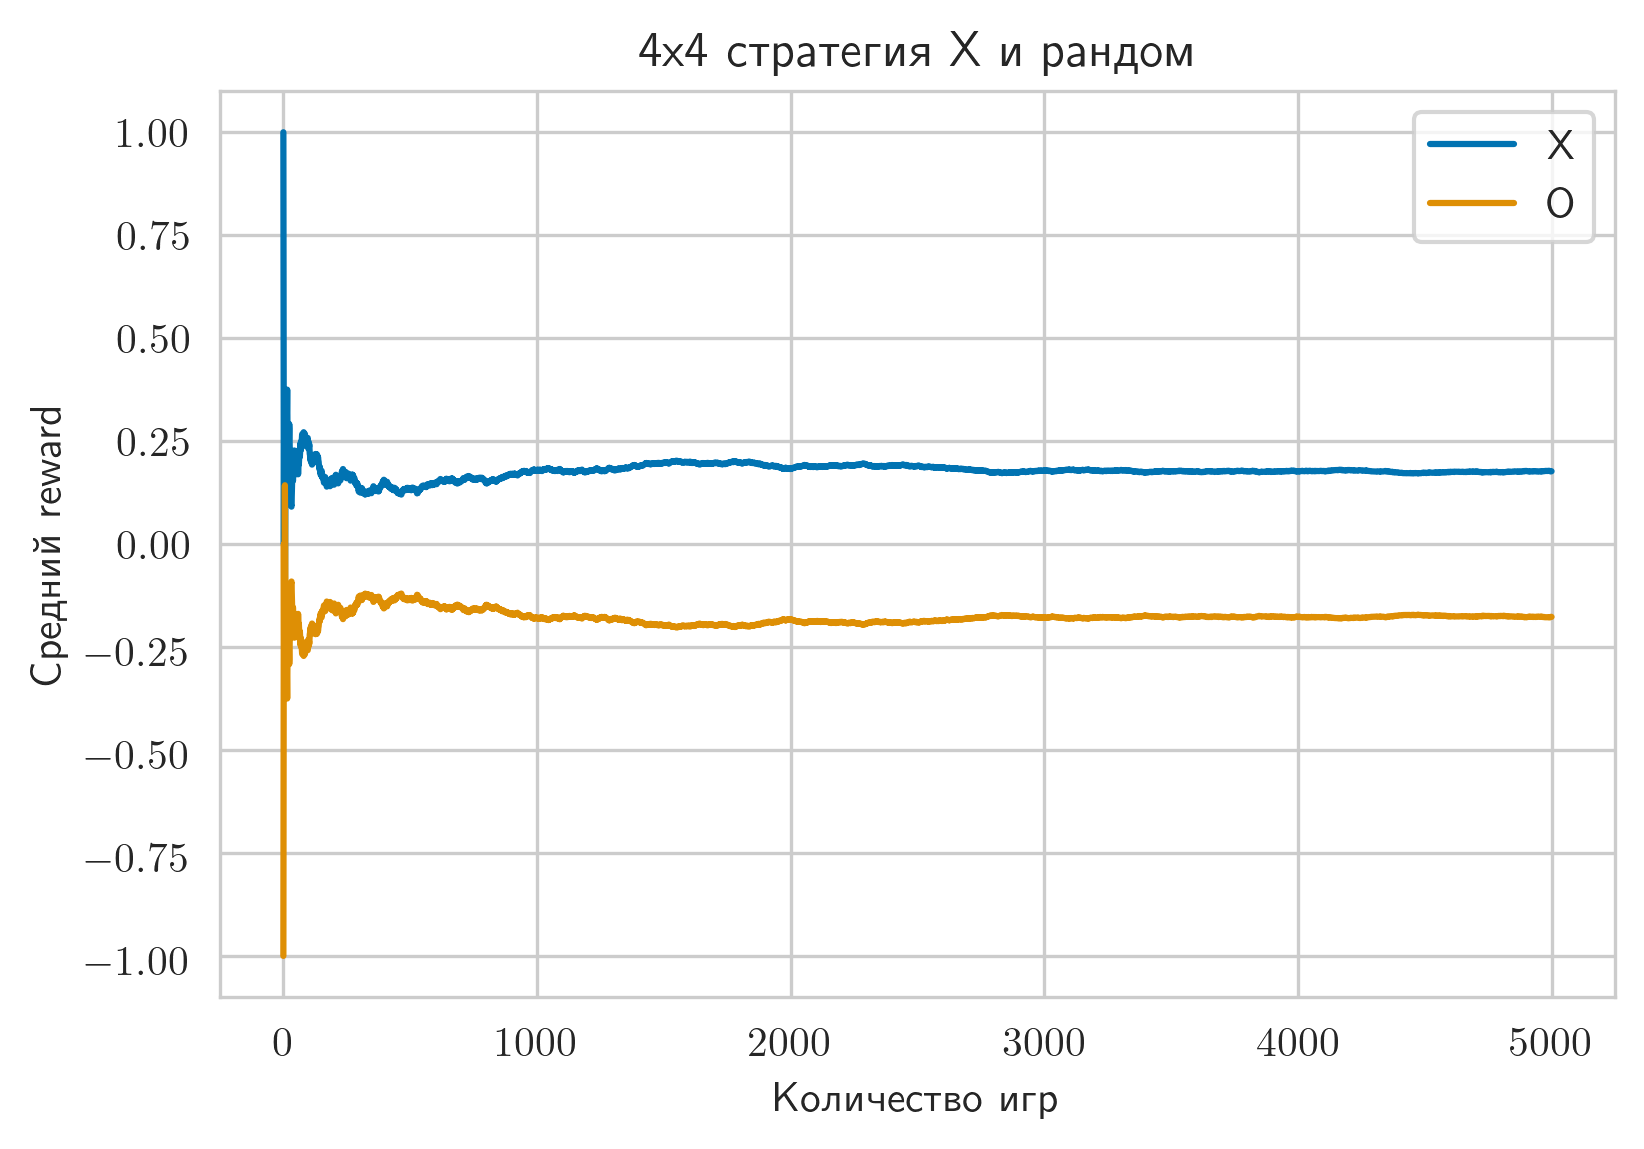

In [806]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, None)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

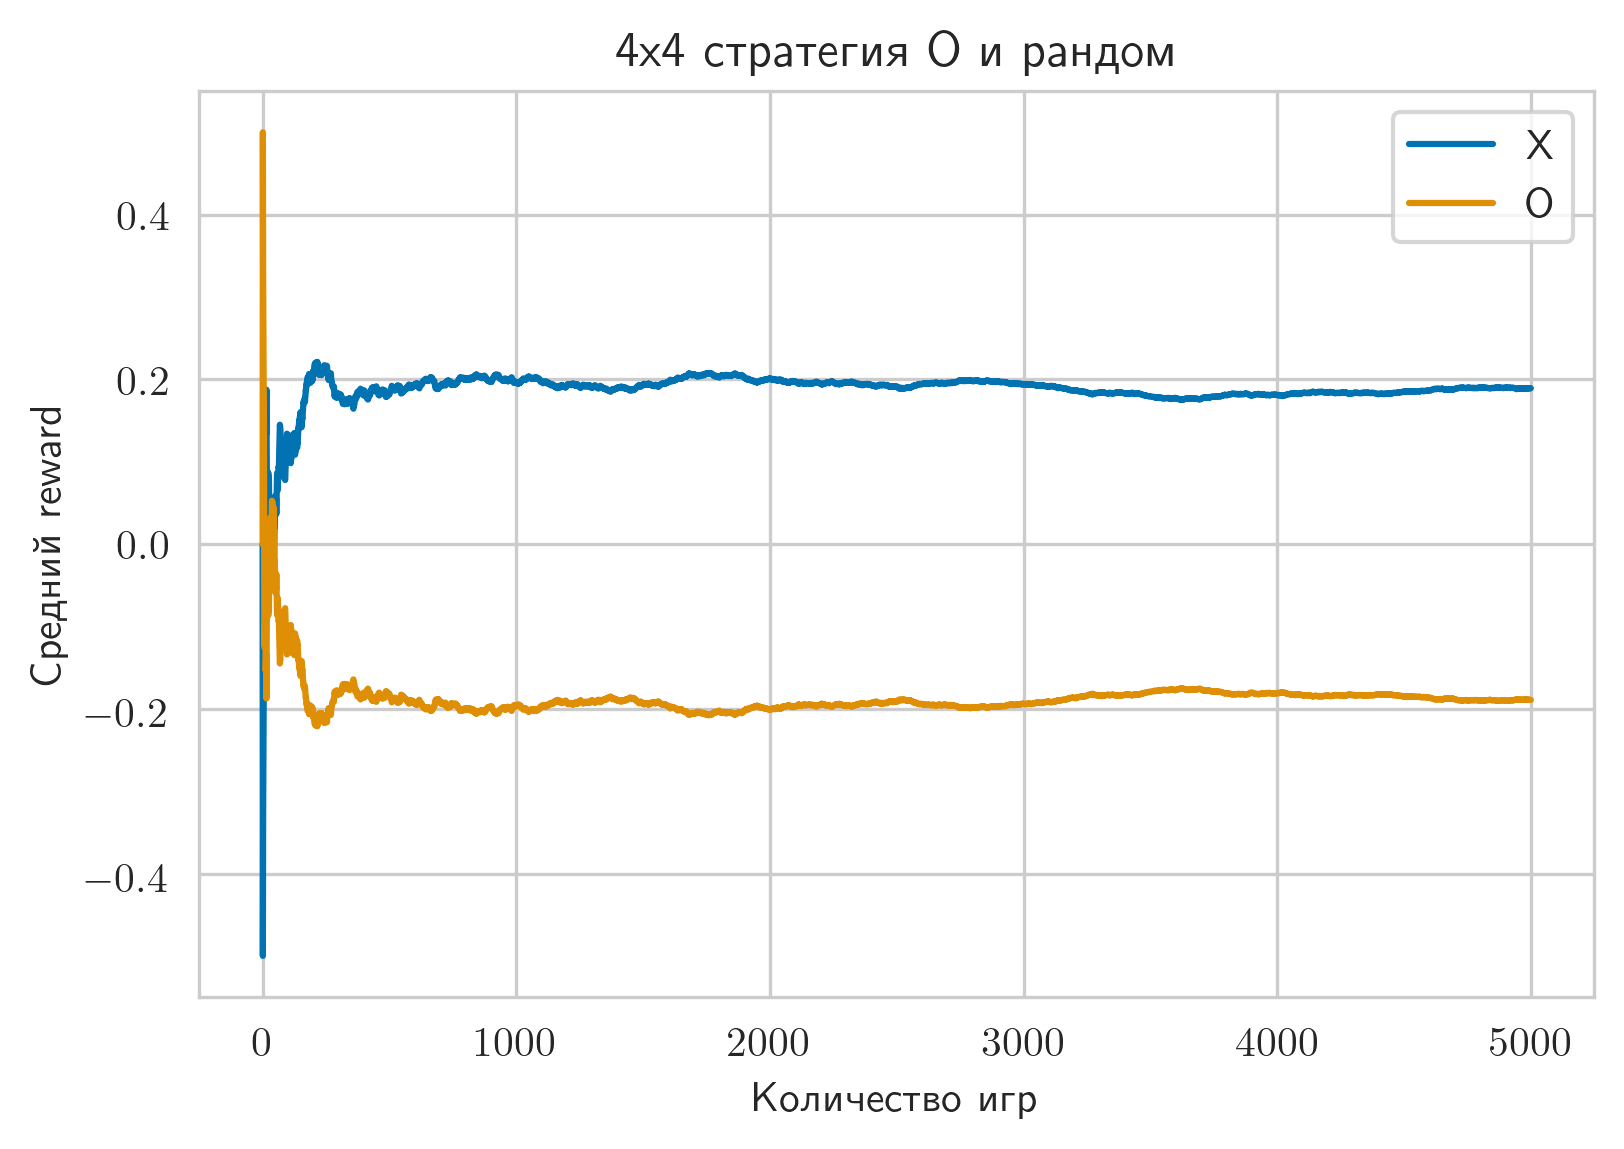

In [805]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, None, dqn.model_o)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 стратегия O и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

### Dueling DQN

In [833]:
class Network(nn.Module):
    def __init__(self, channels=8, linear=8, actions=9):
        nn.Module.__init__(self)
        self.l1 = nn.Conv2d(1, channels, 3)
        self.flatten = nn.Flatten()
        self.l2 = nn.Linear(linear, 24)
        self.values = nn.Linear(24, 1)
        self.advantages = nn.Linear(24, actions)

    def forward(self, x):
        features = self.l2(self.flatten(F.relu(self.l1(x))))
        values = self.values(features)
        advantages = self.advantages(features.view(features.size(0), -1))
        return values + (advantages - advantages.mean())

### 3x3

In [834]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
num_episodes = 10000
dqn = TicTacToeDQN(num_episodes, batch_size=32, actions=9)

In [835]:
dqn.run_episodes(env)

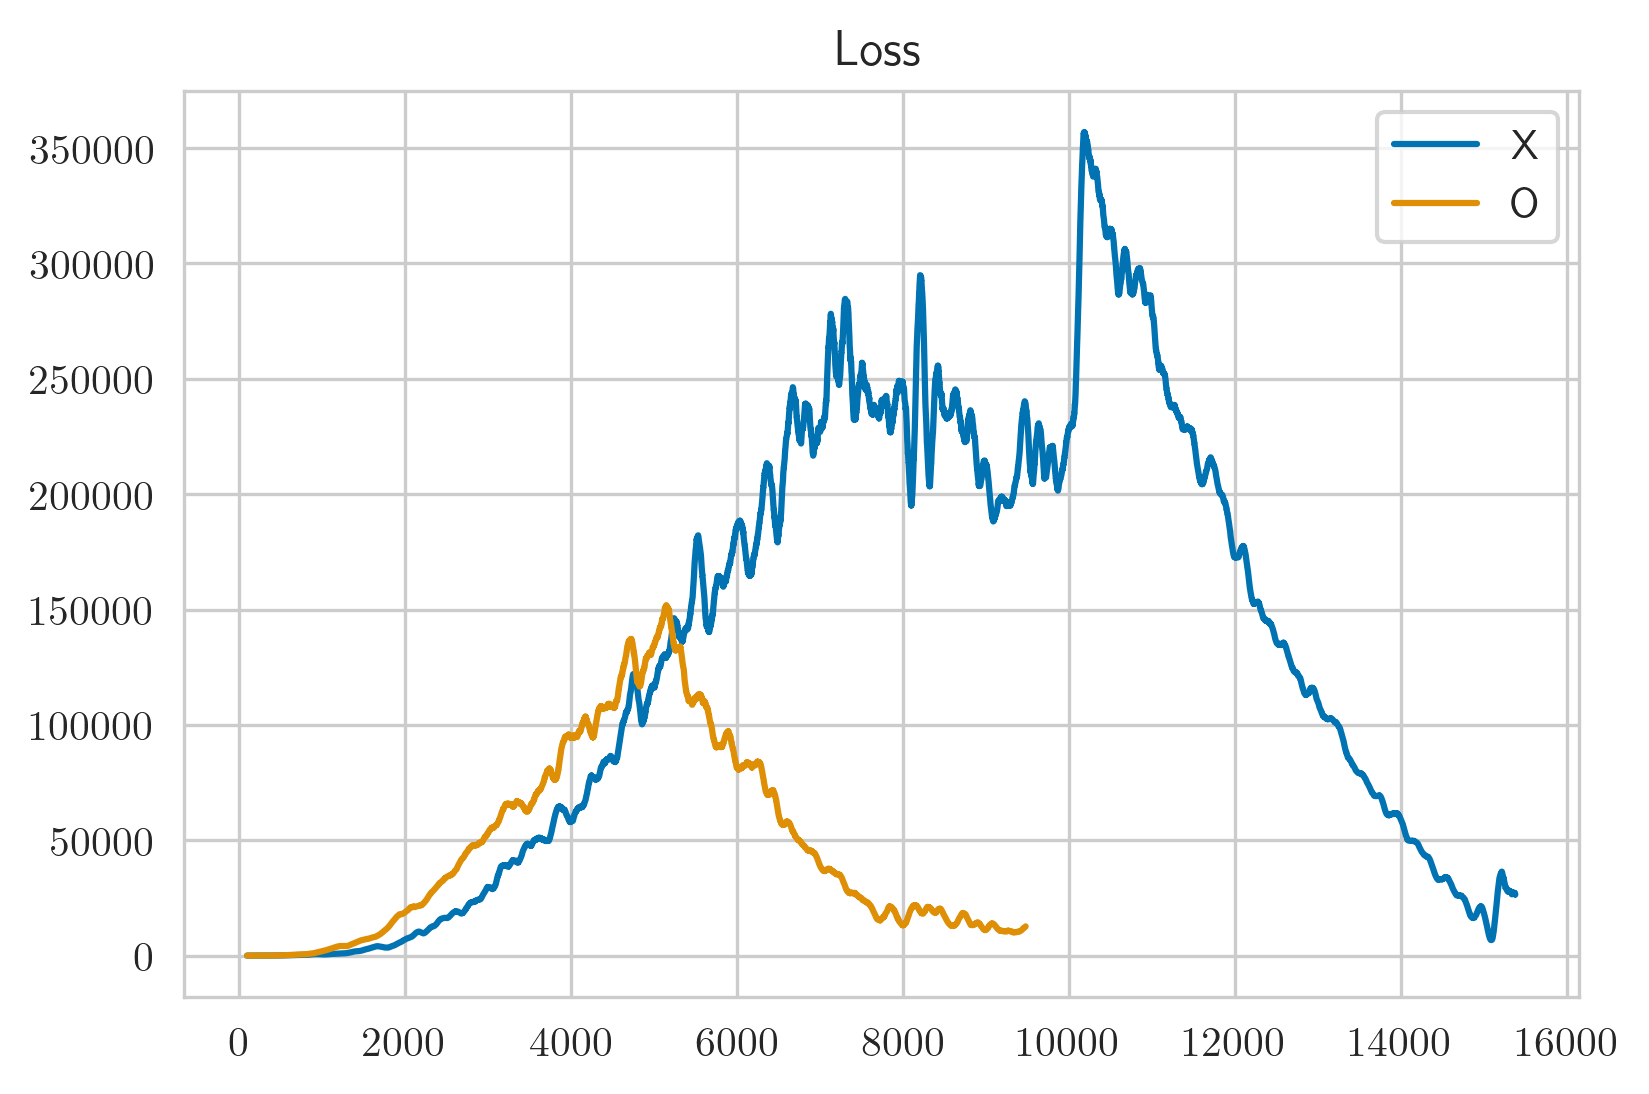

In [836]:
plt.plot(pd.Series(dqn.losses_x).rolling(100).mean(), label='X')
plt.plot(pd.Series(dqn.losses_o).rolling(100).mean(), label='O')
plt.legend()
plt.title('Loss');

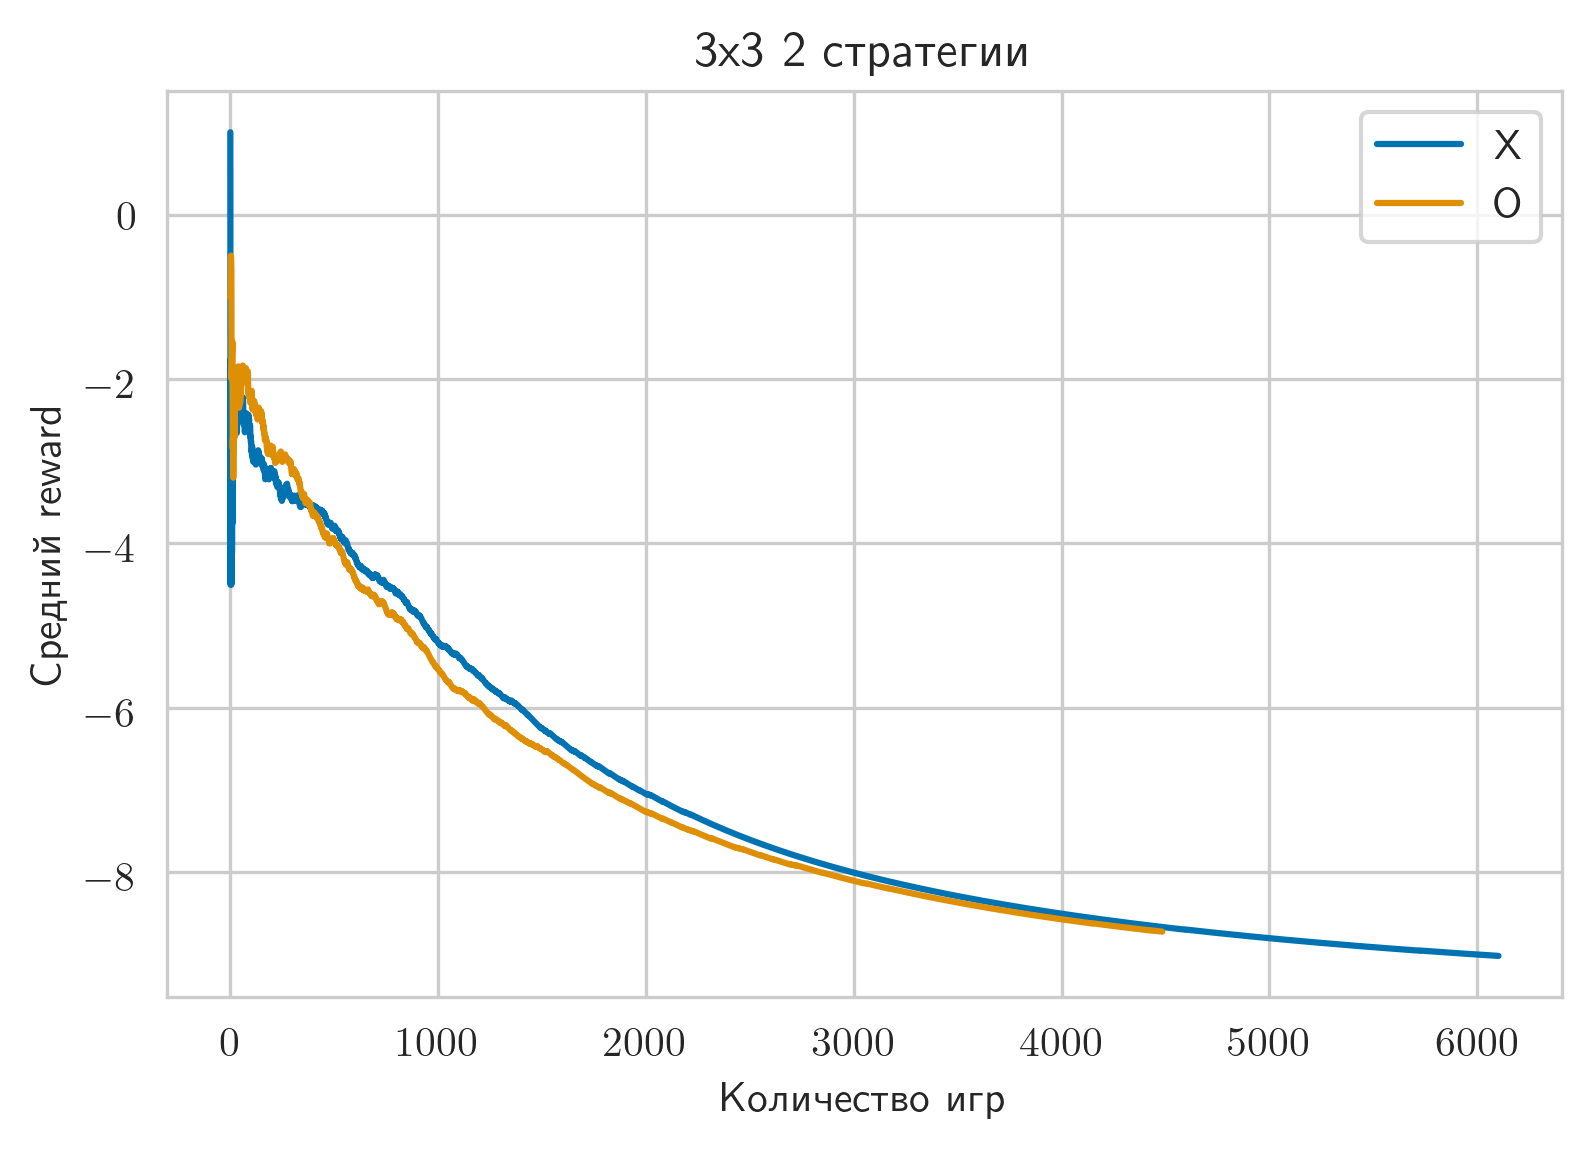

In [837]:
plt.plot(np.cumsum(dqn.rewards_x) / (np.arange(len(dqn.rewards_x)) + 1), label='X')
plt.plot(np.cumsum(dqn.rewards_o) / (np.arange(len(dqn.rewards_o)) + 1), label='O')
plt.title('3x3 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

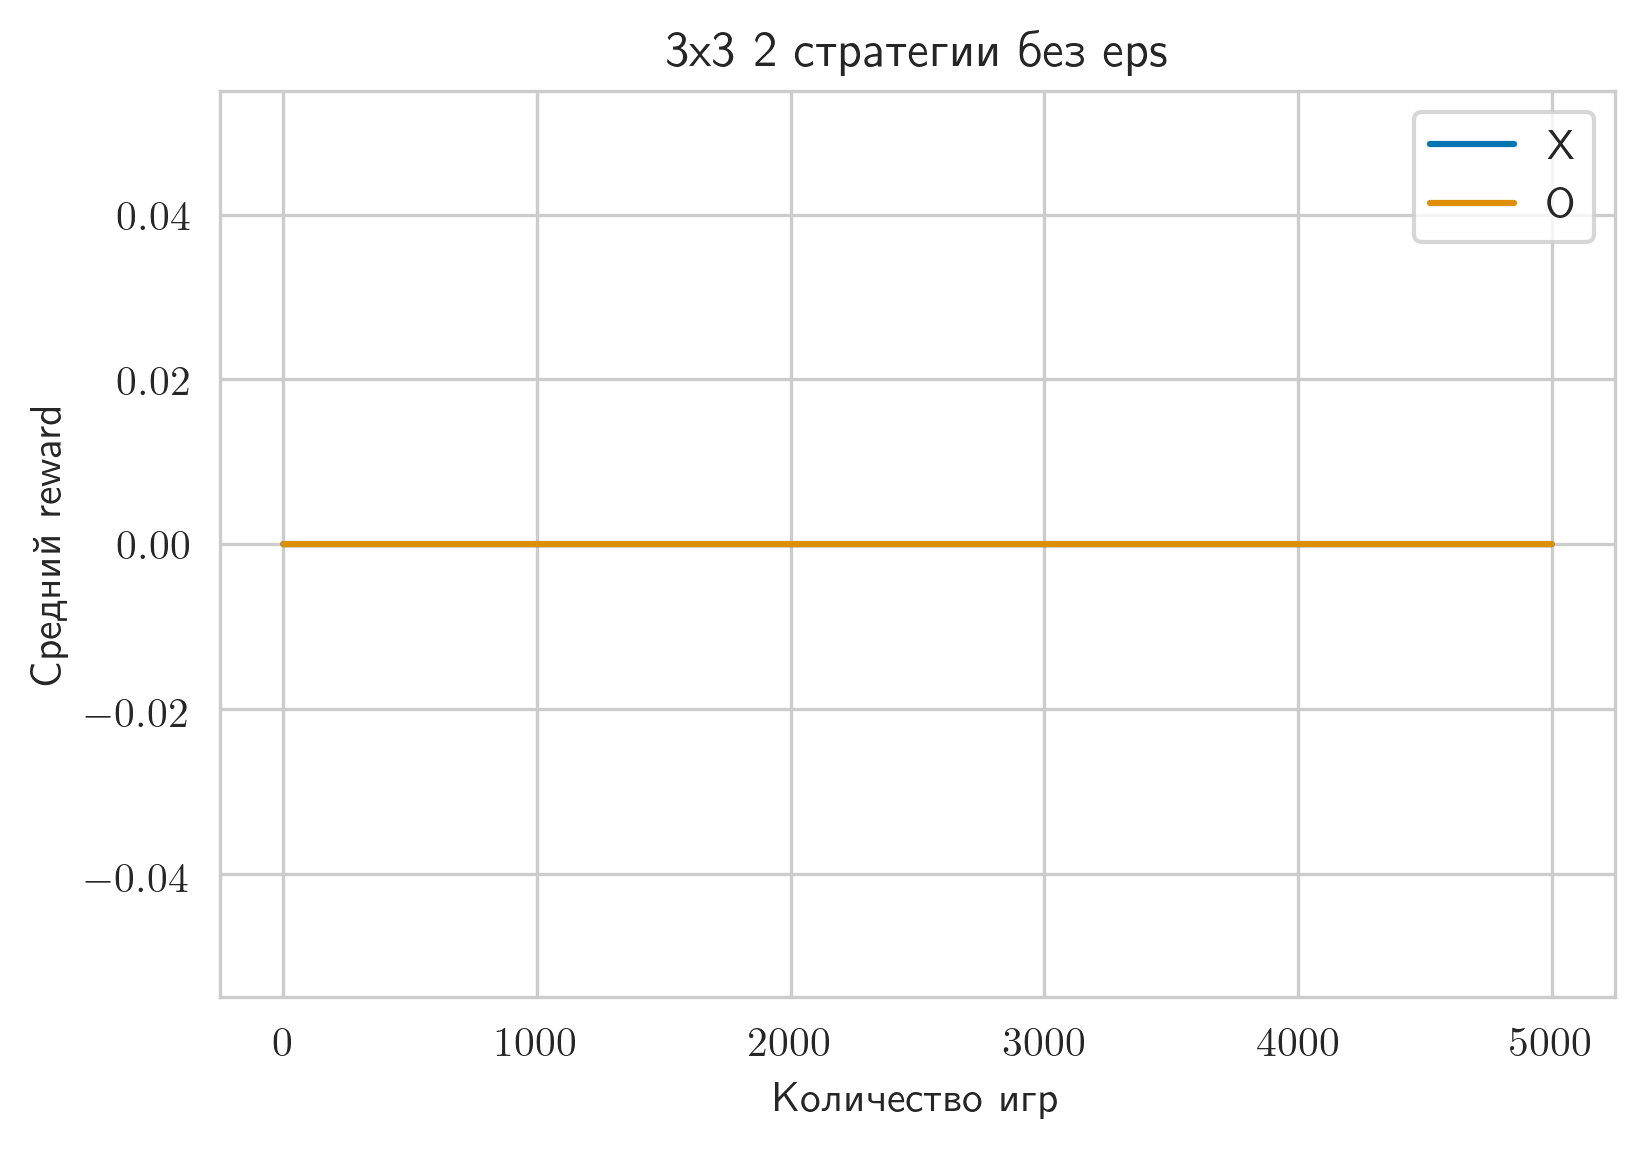

In [838]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, dqn.model_o)
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

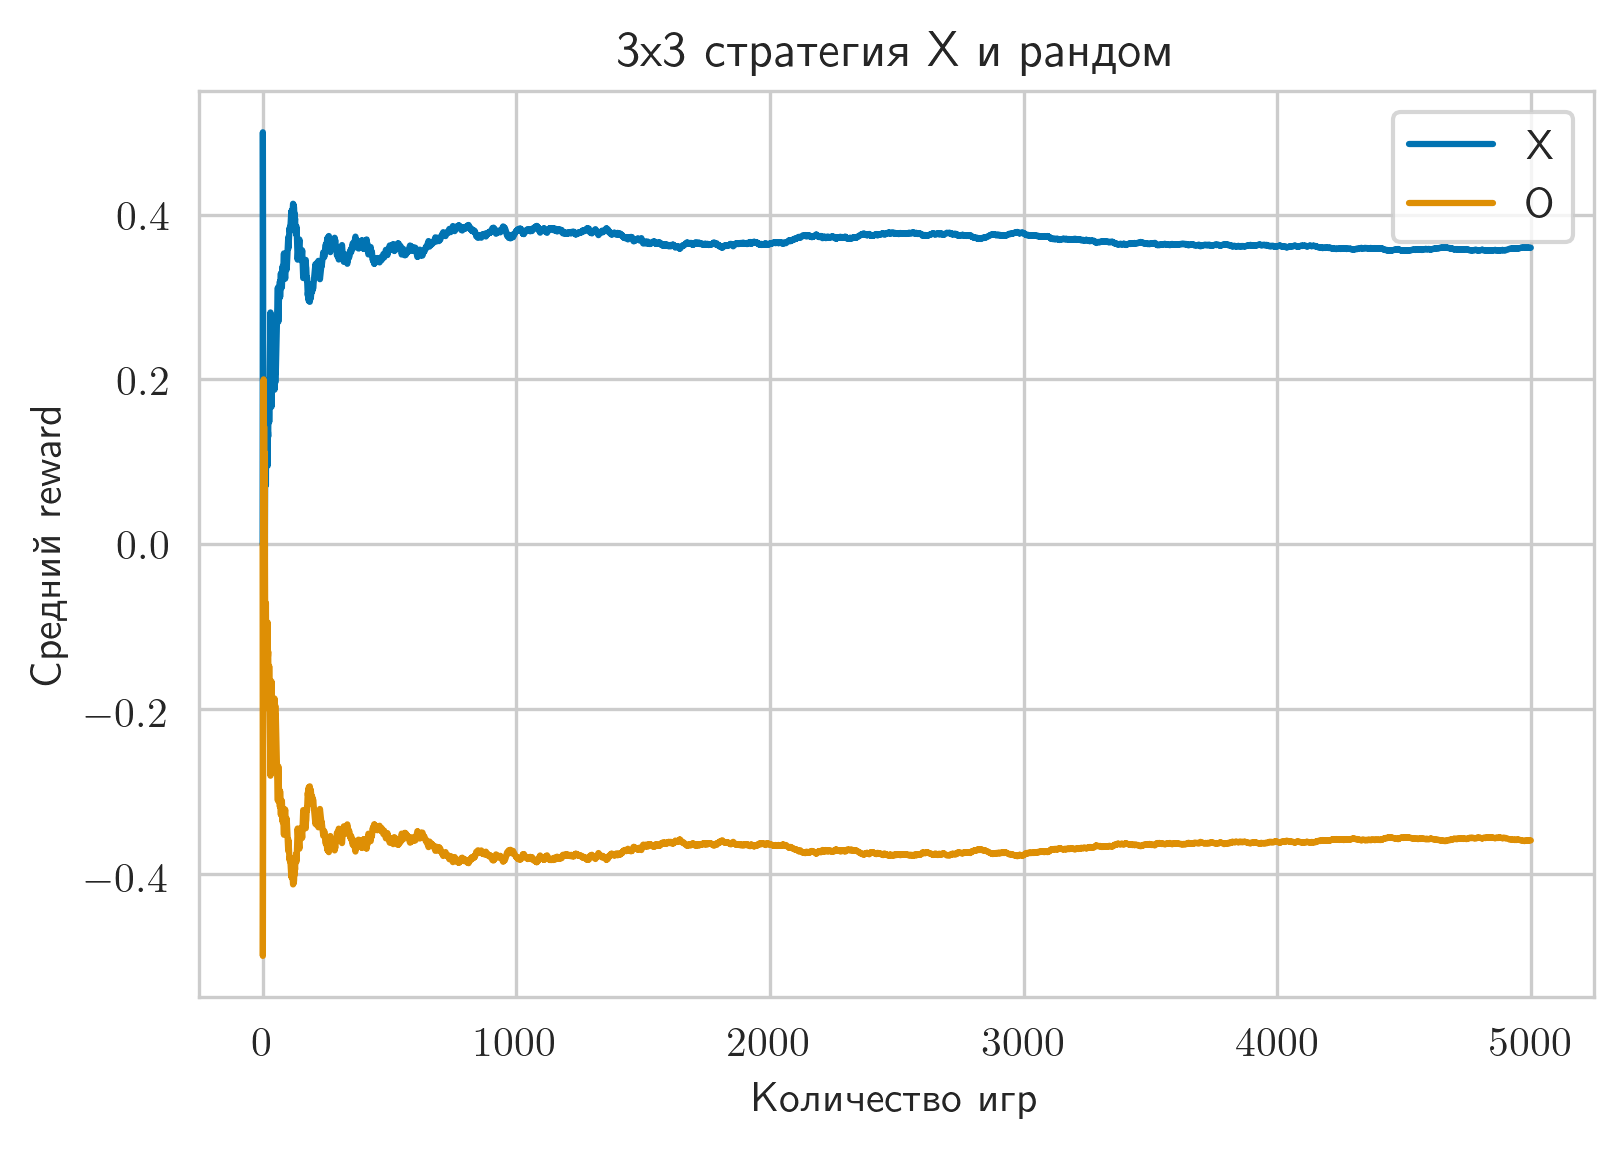

In [839]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, None)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('3x3 стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

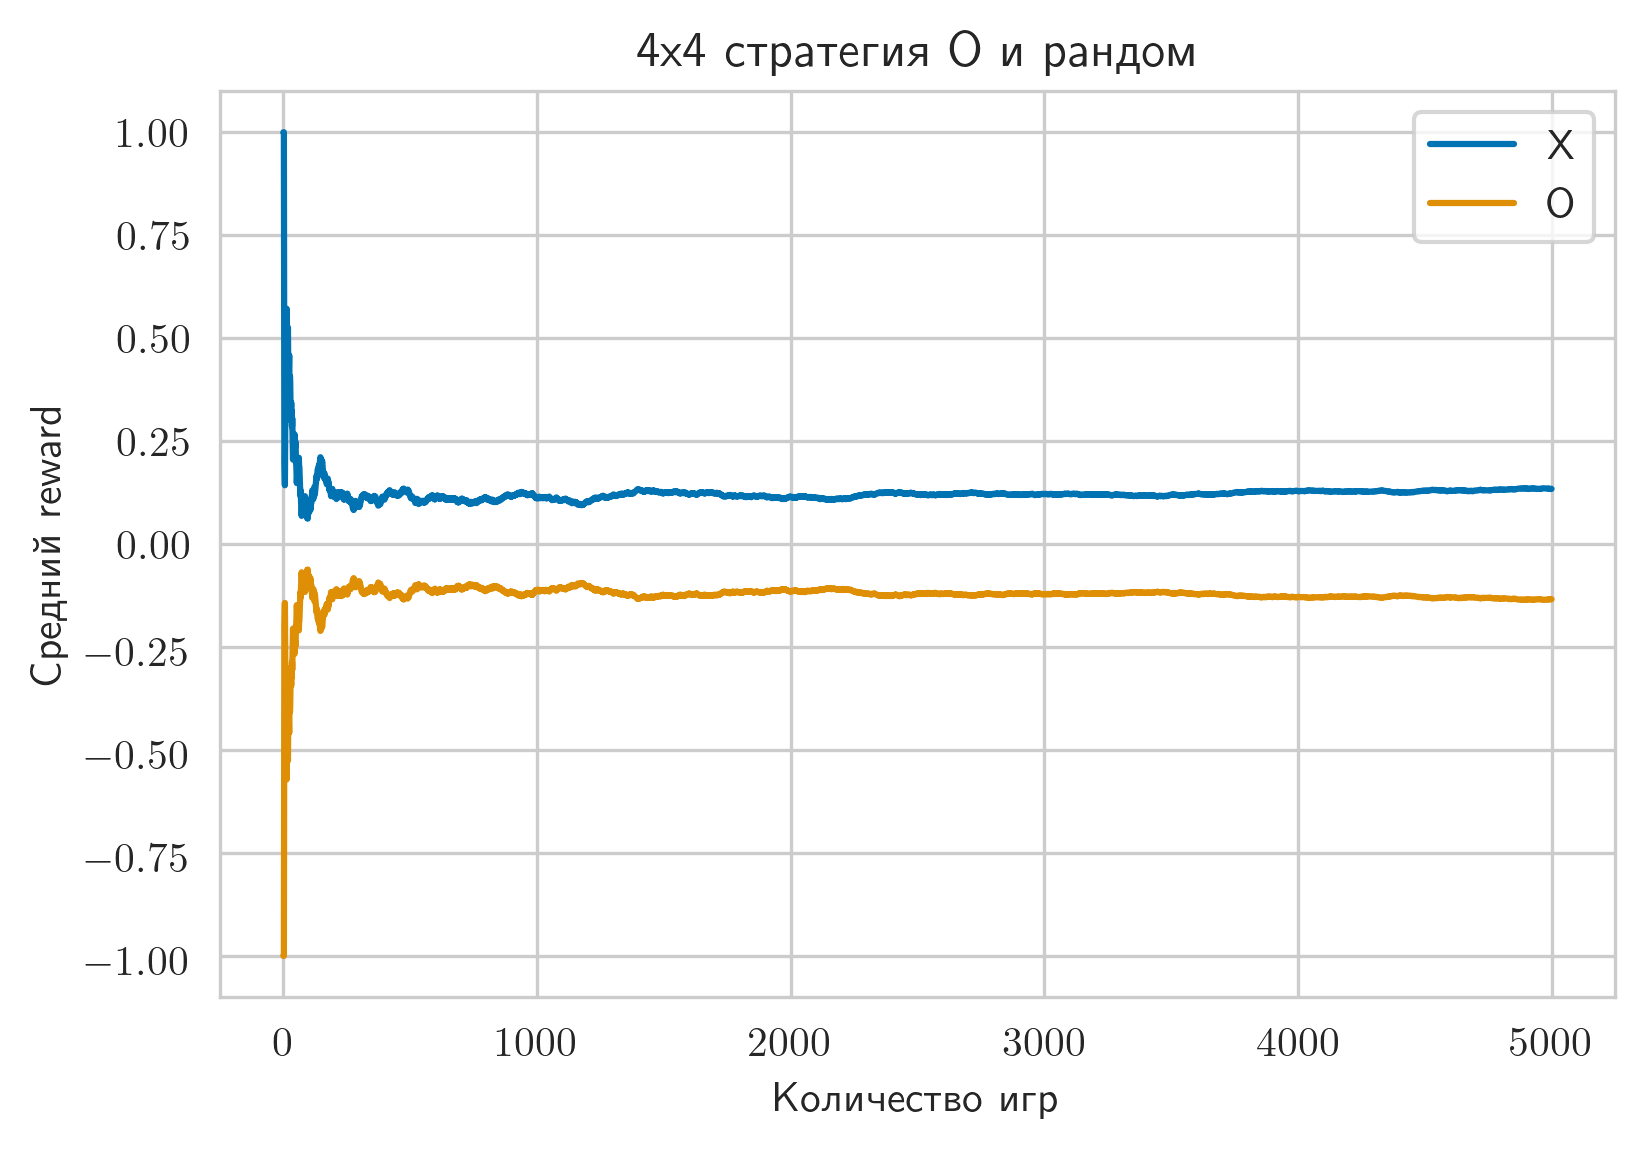

In [840]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, None, dqn.model_o)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 стратегия O и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

### 4x4 

In [844]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
num_episodes = 20000
dqn = TicTacToeDQN(num_episodes, batch_size=32, linear=64, actions=16)

In [845]:
dqn.run_episodes(env)

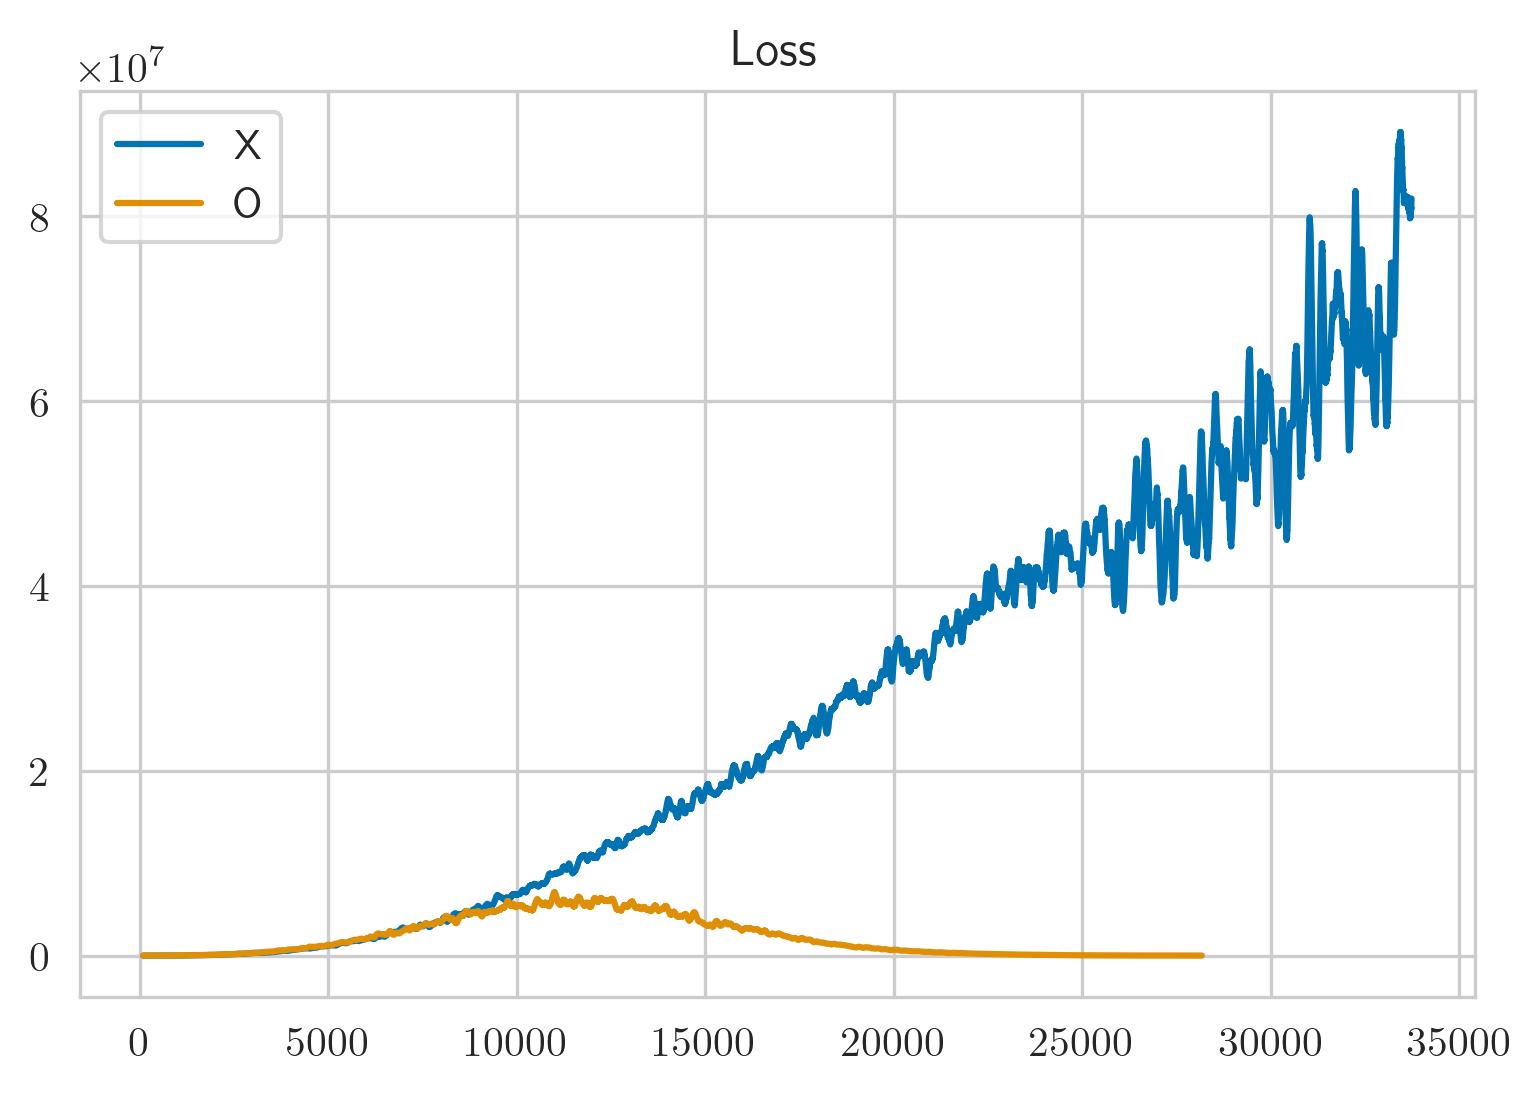

In [846]:
plt.plot(pd.Series(dqn.losses_x).rolling(100).mean(), label='X')
plt.plot(pd.Series(dqn.losses_o).rolling(100).mean(), label='O')
plt.legend()
plt.title('Loss');

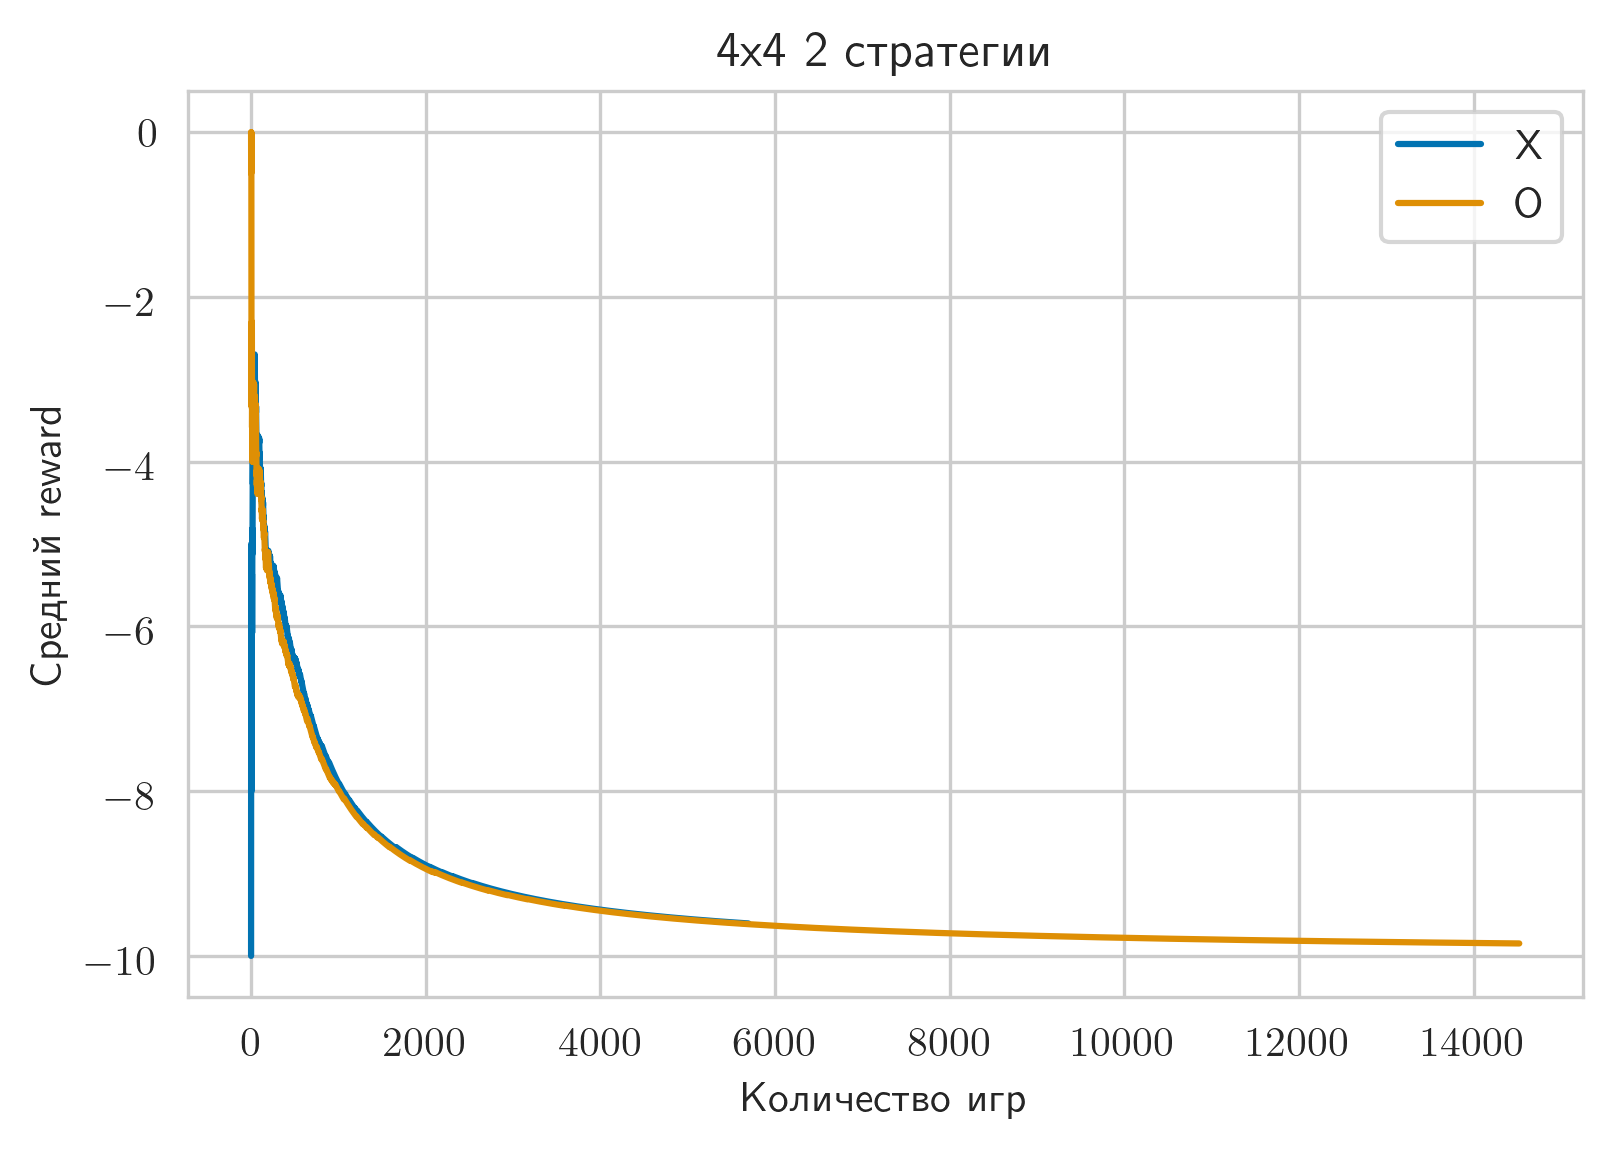

In [847]:
plt.plot(np.cumsum(dqn.rewards_x) / (np.arange(len(dqn.rewards_x)) + 1), label='X')
plt.plot(np.cumsum(dqn.rewards_o) / (np.arange(len(dqn.rewards_o)) + 1), label='O')
plt.title('4x4 2 стратегии')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

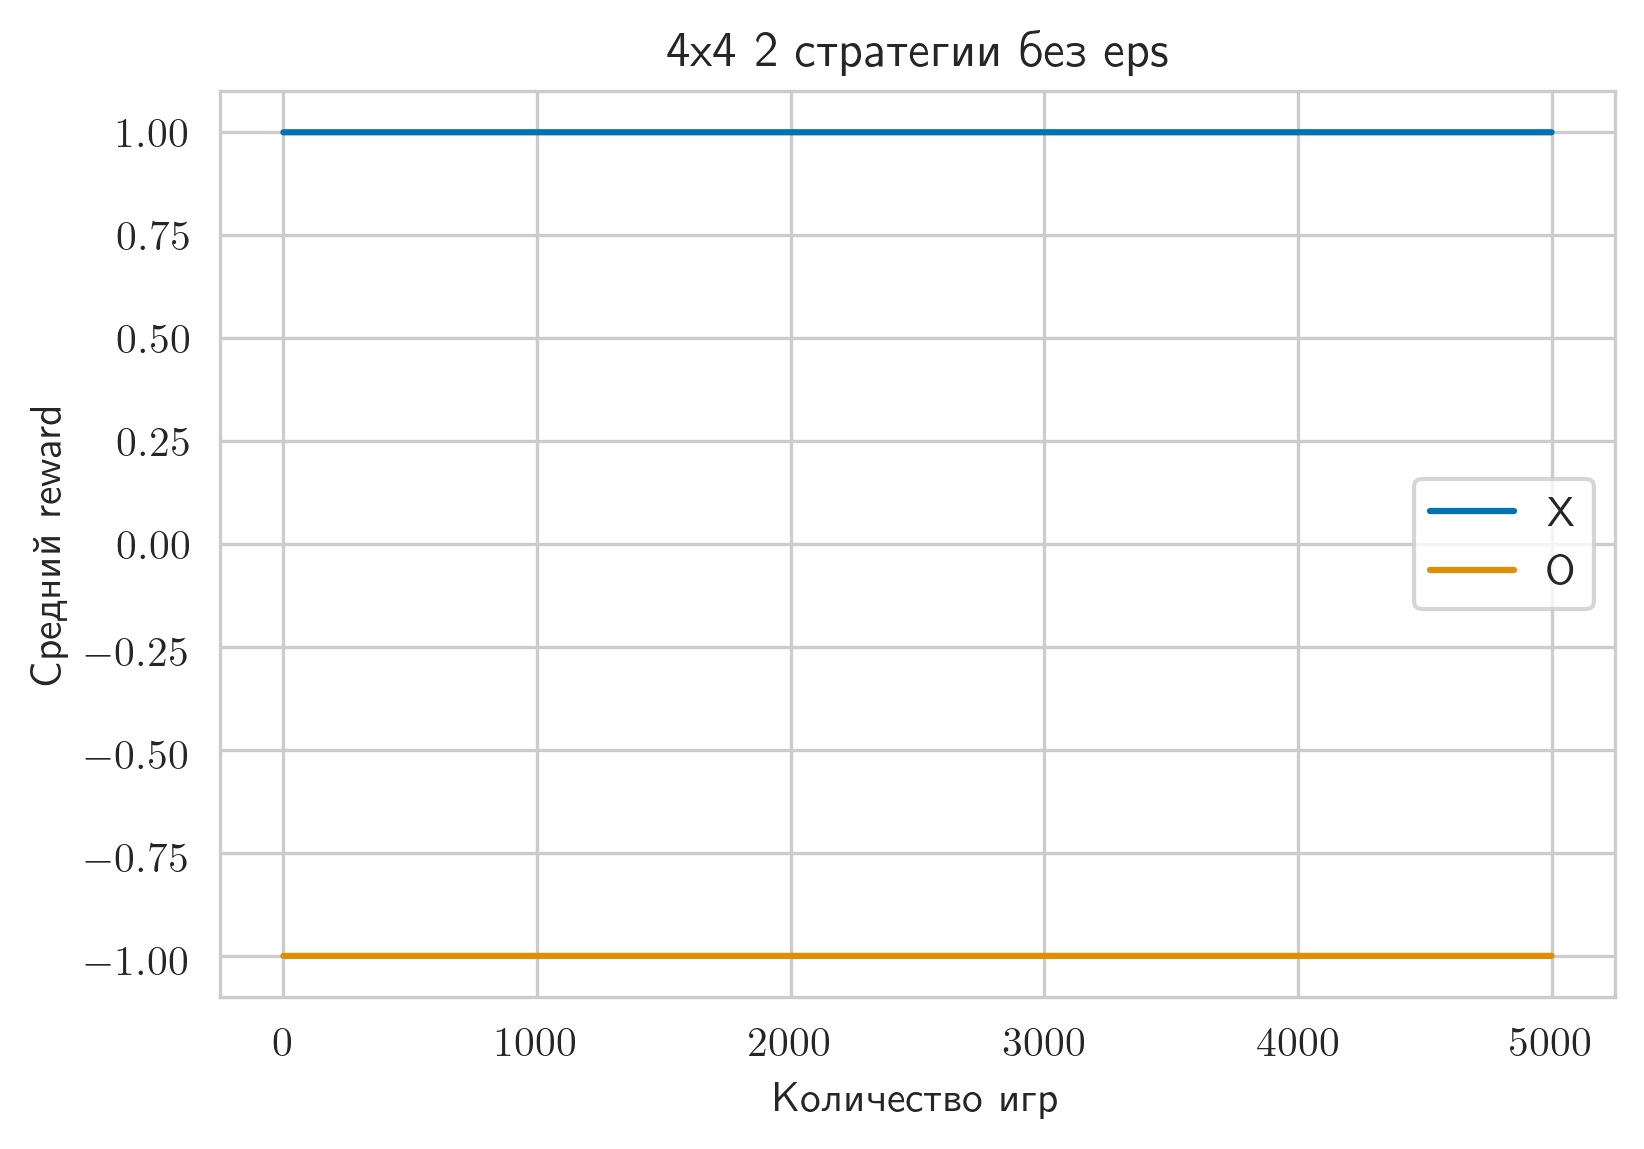

In [848]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, dqn.model_o)
plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 2 стратегии без eps')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

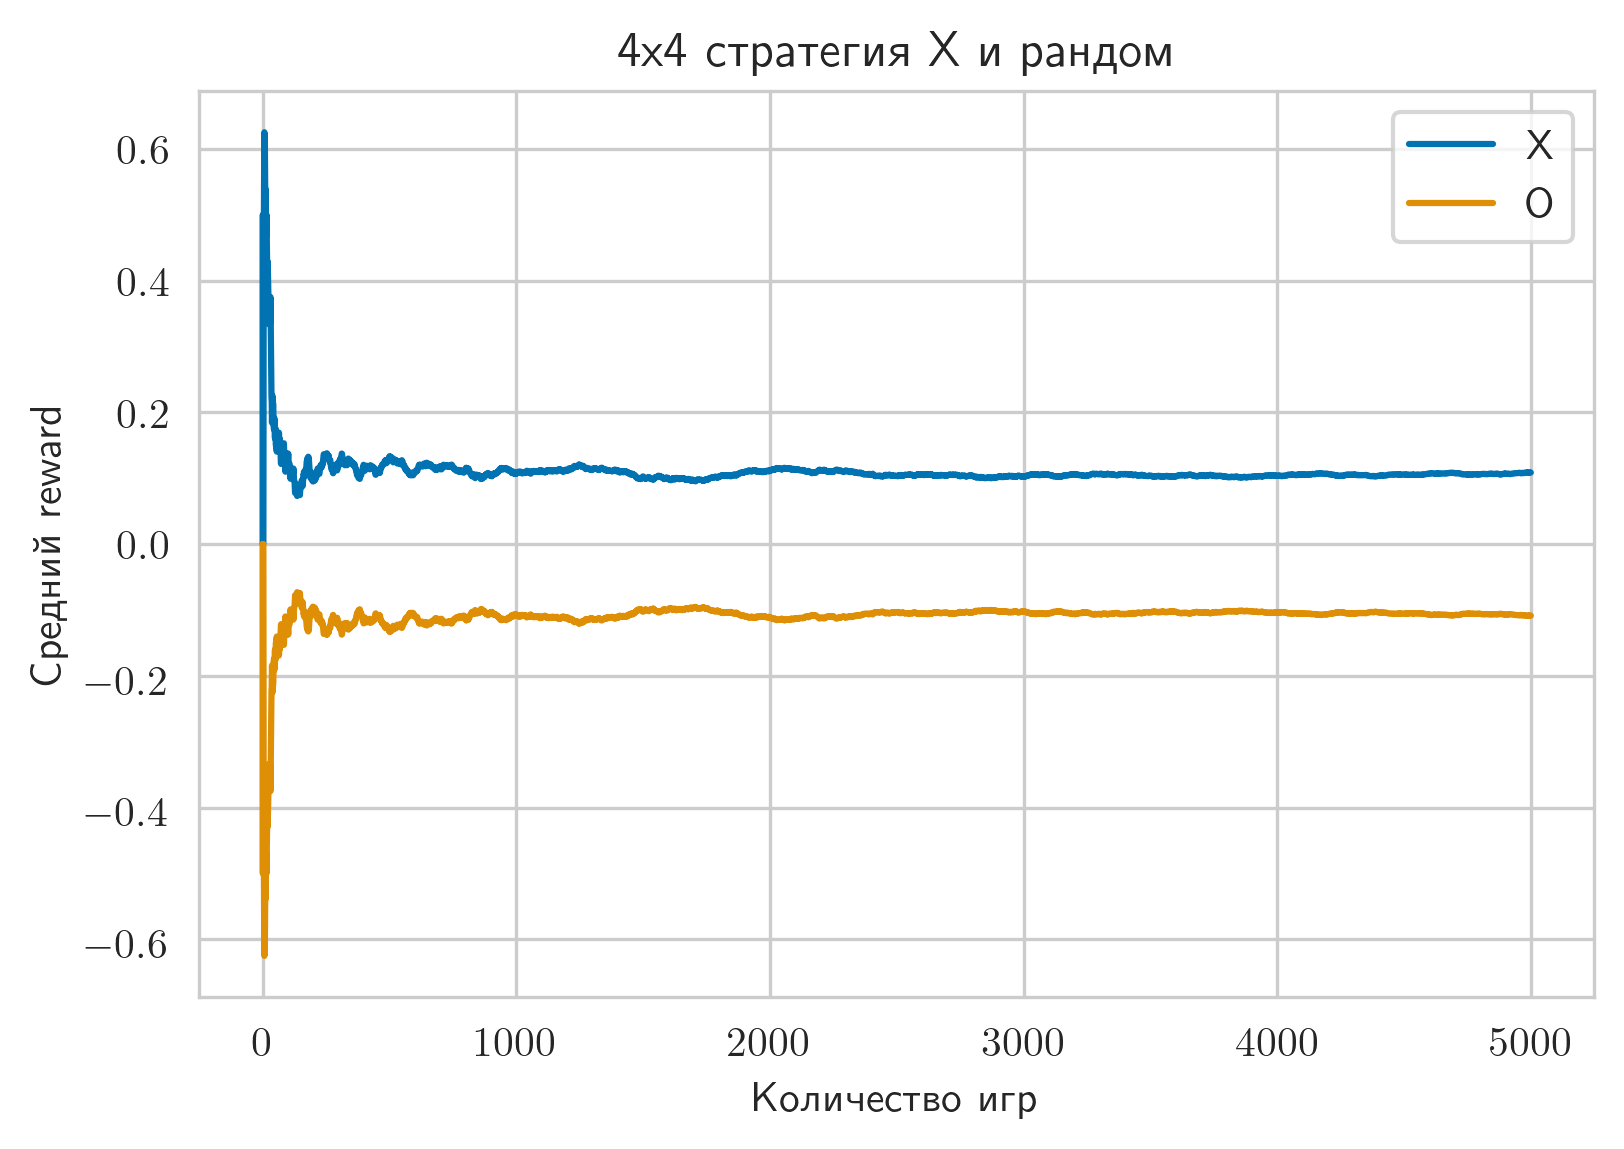

In [849]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, dqn.model_x, None)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 стратегия X и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");

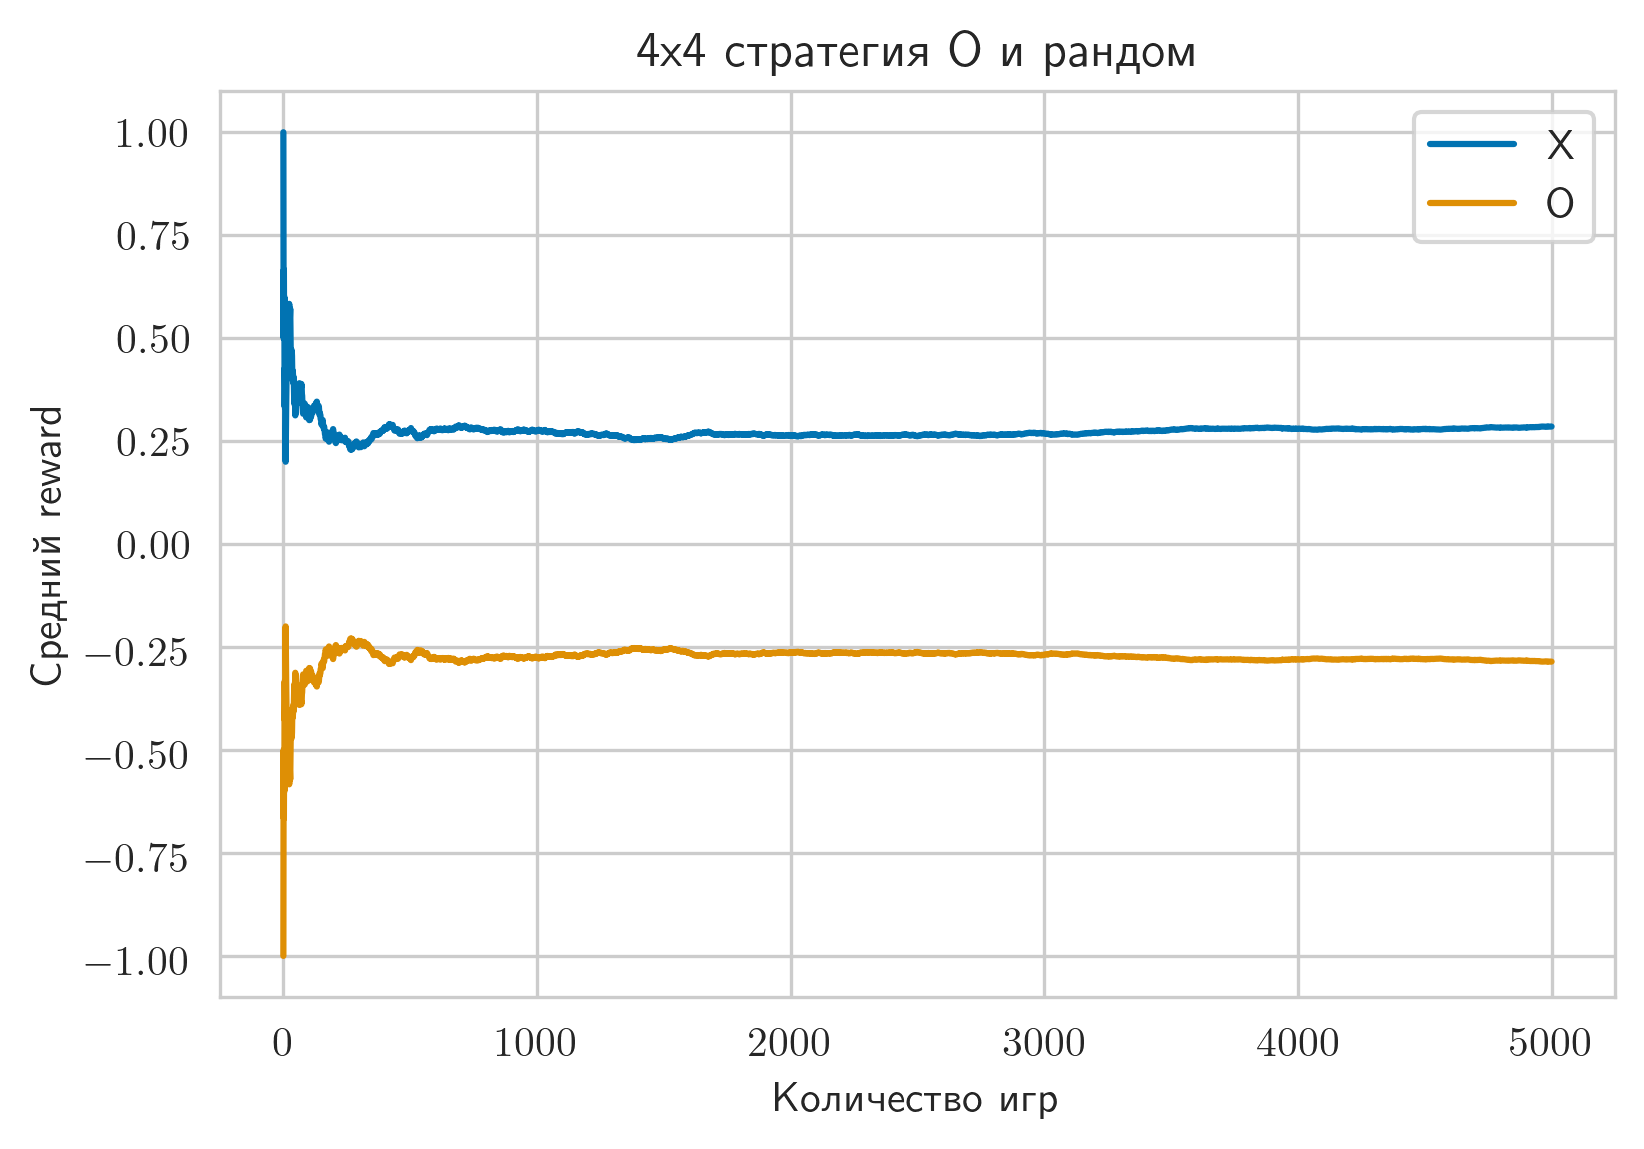

In [850]:
num_episodes = 5000
rewards_x, rewards_o = run_best_Q_strategy(env, num_episodes, None, dqn.model_o)

plt.plot(rewards_x, label='X')
plt.plot(rewards_o, label='O')
plt.title('4x4 стратегия O и рандом')
plt.legend()
plt.ylabel("Средний reward")
plt.xlabel("Количество игр");